# Introduction to Geospatial Data Analysis 2024 - 2025
## Final Mini Project - Due: April 16
### Isil Oral & Tatyana Yakushina

* Project on green gentrification in Vienna through social status index, green spaces, blue areas, and housing prices 

In [1]:
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
import osmnx as ox  
import contextily as ctx
from geopy.geocoders import Nominatim  
from geopy.extra.rate_limiter import RateLimiter
import os
!pip install h3
import h3
import matplotlib.patches as mpatches

In [2]:
# Get the current working directory
current_path = os.getcwd()

# Define relative paths for data, output, and helper functions
data_in = os.path.join(current_path, "data")       # Folder with input data
output = os.path.join(current_path, "output")      # Folder for saving results

### Urban green spaces data 
Data is from 'Open Data Austria', obtained through *Riepl et. al (2025)*

In [3]:
file_name = 'data/OEFFGRUENFLOGD.json'
gdf_green = gpd.read_file(file_name)
gdf_green.head(3)

id  OBJECTID       TEXT13ID F_TYP               T_TEXT  \
0  OEFFGRUENFLOGD.2289      2289  Währinger Pa*     L       Währinger Park   
1  OEFFGRUENFLOGD.2290      2290  Türkenschanz*     L    Türkenschanzplatz   
2  OEFFGRUENFLOGD.2291      2291    Kongreßpark     L  Kongreßpark/Kainzga   

              T_LANG  O       P  O_UEREG  O_REGION  ...  Q_GRI  Q_HUN  Q_BAB  \
0     Währinger Park  1  100000        0         0  ...      0      1      0   
1  Türkenschanzplatz  1       1        0         0  ...      0      0      0   
2         Kainzgasse  1  100000        0         0  ...      0      1      0   

   Q_WC  Q_SPO  Q_TRB       UMFANG       FLAECHE  SE_ANNO_CAD_DATA  \
0     1   1245      1  1460.941451  57020.131903              None   
1     0      0      0   310.900196   2002.715993              None   
2     2     12      1   249.284876   3243.484789              None   

                                            geometry  
0  MULTIPOLYGON (((16.35083 48.23369, 16.34929 48...  
1  POLYGON ((16.32886 48.23482, 16.32824 48.23492...  
2  POLYGON ((16.30871 48.22281, 16.30933 48.22285...  

[3 rows x 35 columns]

In [4]:
# to learn whether there is metadata, if yes what columns mean

import fiona
with fiona.open(file_name) as src:
    #print(src.schema)  # Gives field names and types
    print(src.meta)    # Sometimes includes more metadata

{'driver': 'GeoJSON', 'schema': {'properties': OrderedDict([('id', 'str'), ('OBJECTID', 'int'), ('TEXT13ID', 'str'), ('F_TYP', 'str'), ('T_TEXT', 'str'), ('T_LANG', 'str'), ('O', 'int'), ('P', 'int'), ('O_UEREG', 'int'), ('O_REGION', 'int'), ('O_LOKAL', 'int'), ('P_WLD', 'int'), ('P_WAS', 'int'), ('P_WIE', 'int'), ('P_WGT', 'int'), ('P_LW', 'int'), ('P_PK', 'int'), ('P_GPK', 'int'), ('P_GST', 'int'), ('P_SGR', 'int'), ('P_AGR', 'int'), ('P_RGR', 'int'), ('P_URB', 'int'), ('Q_MOB', 'int'), ('Q_SPI', 'int'), ('Q_GRI', 'int'), ('Q_HUN', 'int'), ('Q_BAB', 'int'), ('Q_WC', 'int'), ('Q_SPO', 'int'), ('Q_TRB', 'int'), ('UMFANG', 'float'), ('FLAECHE', 'float'), ('SE_ANNO_CAD_DATA', 'str')]), 'geometry': 'Unknown'}, 'crs': {'init': 'epsg:4326'}, 'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Lati

### Some social and economic data for each census district of Vienna
Data is from 'Open Data Austria', obtained through *Riepl et. al (2025)*

In [5]:
gdf_census = gpd.read_file('data/data_ssi.geojson')
gdf_census

ZBEZ  university_share  avg_income  unemprate  benefit_share       SSI  \
0    0101          1.604954    1.741399   1.125923       1.123008  1.653992   
1    0102          1.653812    2.565233   1.237000       1.139440  2.000434   
2    0103          1.706598    3.805033   1.641029       1.232519  2.570582   
3    0104          1.845975    3.156000   1.697713       1.313290  2.407460   
4    0105          1.681303    2.424953   1.192502       1.252134  1.971322   
..    ...               ...         ...        ...            ...       ...   
241  2315          1.267620    2.076986   1.032159       0.955199  1.604961   
242  2316         -0.038446    0.315260   0.839466       0.834993  0.412143   
243  2317         -0.410833    0.503589   0.921774       1.088109  0.406096   
244  2318         -1.138054   -0.177753  -0.123182       0.210761 -0.470587   
245  2319         -0.637727    0.119944   0.326024       0.481803 -0.042126   

     quintile                                           geometry  
0           5  POLYGON ((16.37903 48.21187, 16.37902 48.21188...  
1           5  POLYGON ((16.37906 48.20748, 16.37882 48.20755...  
2           5  POLYGON ((16.36893 48.20072, 16.36905 48.20072...  
3           5  POLYGON ((16.36326 48.20390, 16.36383 48.20424...  
4           5  POLYGON ((16.36765 48.21307, 16.36843 48.21273...  
..        ...                                                ...  
241         5  POLYGON ((16.26417 48.15314, 16.26433 48.15320...  
242         4  POLYGON ((16.23894 48.15341, 16.23821 48.15312...  
243         4  POLYGON ((16.37712 48.14752, 16.37708 48.14753...  
244         2  POLYGON ((16.34062 48.14870, 16.34051 48.14871...  
245         3  POLYGON ((16.31753 48.15390, 16.31748 48.15389...  

[246 rows x 8 columns]

In [6]:
with fiona.open('data/data_ssi.geojson') as src:
    #sprint(src.schema)  # Gives field names and types
    print(src.meta)    # Sometimes includes more metadata

{'driver': 'GeoJSON', 'schema': {'properties': OrderedDict([('ZBEZ', 'str'), ('university_share', 'float'), ('avg_income', 'float'), ('unemprate', 'float'), ('benefit_share', 'float'), ('SSI', 'float'), ('quintile', 'int')]), 'geometry': 'Polygon'}, 'crs': {'init': 'epsg:4326'}, 'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}


### Data for blue spaces and administrative boundaries
Data is from OpenStreetMap

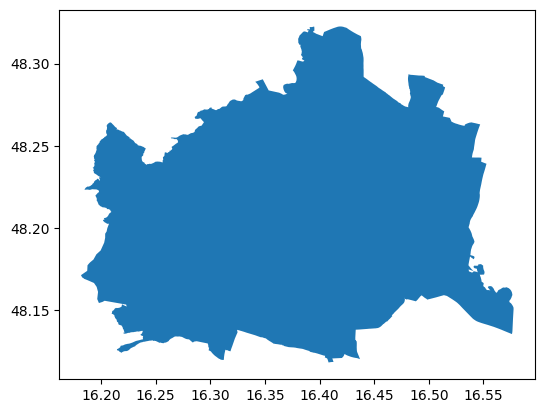

In [7]:
admin_city = ox.geocode_to_gdf('Vienna')
admin_city.plot()
plt.show()

**Blue spaces** are "Outdoor environments—natural or manmade—that prominently feature water, and are accessible and offer opportunities for recreation, relaxation, or aesthetic appreciation." (According to the World Health Organization (WHO) and related research (e.g., BlueHealth project))

This includes:
- Oceans and seas
- Rivers, lakes, ponds
- Canals, streams
- Urban fountains, reservoirs (if accessible)
- Wetlands (if part of nature/recreation areas)

They exclude:
- Wastewater facilities
- Industrial drainage systems
- Hidden/underground pipes
- Non-recreational, restricted areas (e.g. dams, treatment plants)


In [8]:
# Define the polygon for the administrative 
admin_poly = admin_city.geometry.values[0]


# Download POIs for blue spaces within the administrative boundary
tags_blue = {
    'natural': ['water', 'wetland'],
    'waterway': ['stream', 'river', 'canal'],
    'water': ['pond', 'lake', 'reservoir', 'basin', 'fishpond']
}
blue = ox.features_from_polygon(admin_poly, tags=tags_blue)

print("Water sources:", len(blue))
print("Type of data:", type(blue))
blue.head(3)

Water sources: 2207
Type of data: <class 'geopandas.geodataframe.GeoDataFrame'>


source  \
element_type osmid                 
node         6813960988      NaN   
way          3870590     landsat   
             3870688     landsat   

                                                                  geometry  \
element_type osmid                                                           
node         6813960988                          POINT (16.41034 48.13083)   
way          3870590     POLYGON ((16.49867 48.27628, 16.49910 48.27635...   
             3870688     POLYGON ((16.42203 48.23973, 16.42207 48.23983...   

                        created_by odbl river:waterway_distance waterway  \
element_type osmid                                                         
node         6813960988        NaN  NaN                     NaN      NaN   
way          3870590           NaN  NaN                     NaN      NaN   
             3870688           NaN  NaN                     NaN      NaN   

                        seamark:type                 name maxwidth obstacle  \
element_type osmid                                                            
node         6813960988          NaN                  NaN      NaN      NaN   
way          3870590             NaN  Transportbetongrube      NaN      NaN   
             3870688             NaN     Schießstattlacke      NaN      NaN   

                         ... year_of_construction toilets:wheelchair memorial  \
element_type osmid       ...                                                    
node         6813960988  ...                  NaN                NaN      NaN   
way          3870590     ...                  NaN                NaN      NaN   
             3870688     ...                  NaN                NaN      NaN   

                        fence_type abandoned  lit ways attraction name:sh  \
element_type osmid                                                          
node         6813960988        NaN       NaN  NaN  NaN        NaN     NaN   
way          3870590           NaN       NaN  NaN  NaN        NaN     NaN   
             3870688           NaN       NaN  NaN  NaN        NaN     NaN   

                        species:wikidata  
element_type osmid                        
node         6813960988              NaN  
way          3870590                 NaN  
             3870688                 NaN  

[3 rows x 134 columns]

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


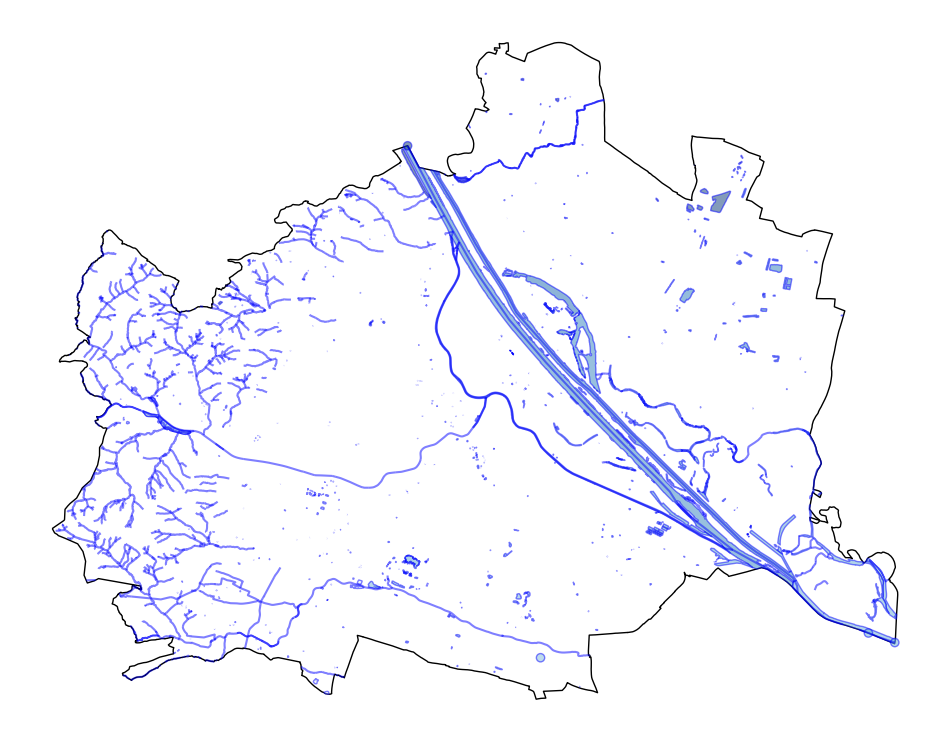

In [9]:
blue_clipped = gpd.clip(blue, admin_city)

# Create a plot to visualize the admin boundary and blue spaces
f, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the administrative boundary
admin_city.plot(ax=ax, color='none', edgecolor='k')

# Plot the parks
blue_clipped.plot(ax=ax, cmap='Blues', alpha=0.5, edgecolor='blue')

# Customize the plot
ax.axis('off')
plt.show()

### Further green space data
The green spaces data can be collected through OpenStreetMap (OSM) by using the following code cell, however, in this project, we sticked to the data prepared and processed by Riepl et. al (2025) for green spaces.

In [10]:
'''
greens = ox.features_from_polygon(admin_poly, tags={'leisure': 'nature_reserve', 'leisure': 'garden', 'leisure': 'park', 'amenity': 'graveyard', 'landuse': 'cemetery', 'landuse': 'recreation_ground', 'landuse': 'forest'})

print("Green spaces:", len(greens))
print("Type of data:", type(greens))
greens.head()
'''

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\ngreens = ox.features_from_polygon(admin_poly, tags={\'leisure\': \'nature_reserve\', \'leisure\': \'garden\', \'leisure\': \'park\', \'amenity\': \'graveyard\', \'landuse\': \'cemetery\', \'landuse\': \'recreation_ground\', \'landuse\': \'forest\'})\n\nprint("Green spaces:", len(greens))\nprint("Type of data:", type(greens))\ngreens.head()\n'

## Visualizations

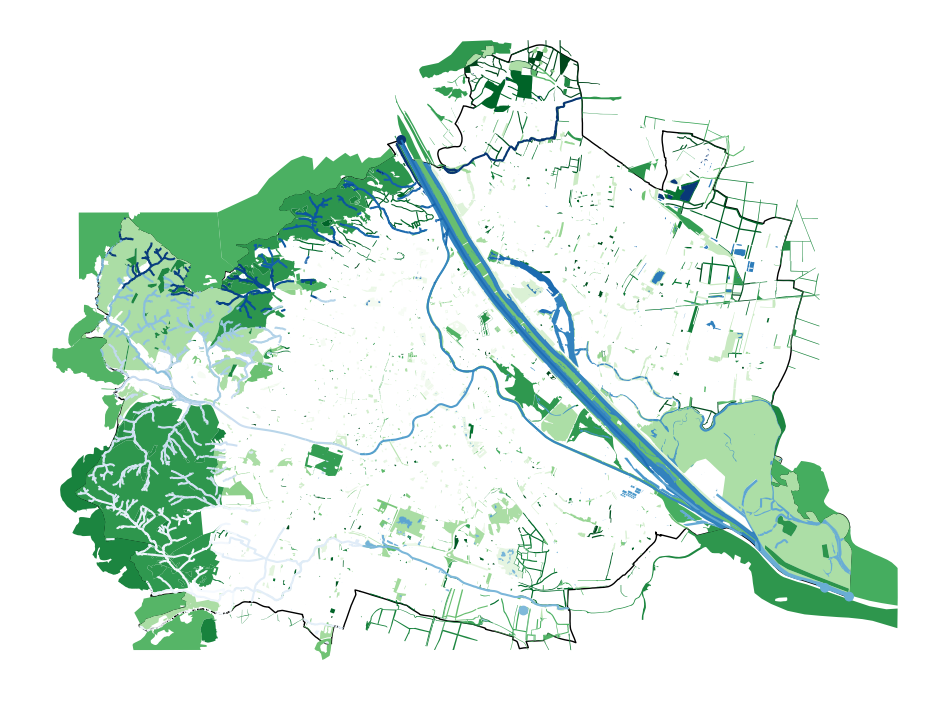

In [11]:
#greens from Open Data Austria, and blues from OSM:

f, ax = plt.subplots(1, 1, figsize=(12, 12))

admin_city.plot(ax=ax, color='none', edgecolor='k')
gdf_green.plot(ax=ax, cmap='Greens')
blue_clipped.plot(ax=ax, cmap='Blues')
ax.axis('off')

plt.savefig("output/vienna_green_blue_map.png", dpi=300, bbox_inches='tight')
plt.show()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


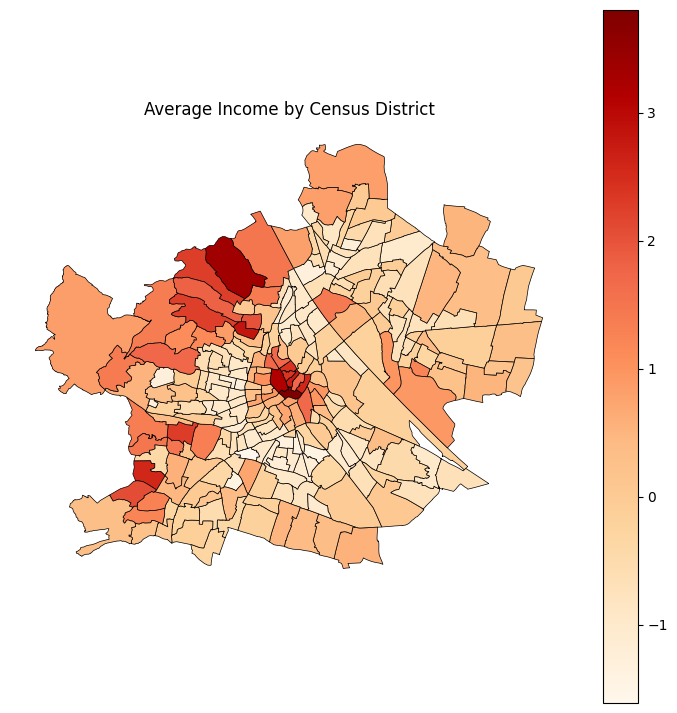

In [12]:
# Plot average income by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='avg_income',     
    cmap='OrRd',              
    linewidth=0.5,            
    edgecolor='black',        
    legend=True,              
    ax=ax
)

ax.set_title("Average Income by Census District", fontsize=12)
ax.axis('off')

plt.savefig("output/avg_income_map.png", dpi=300, bbox_inches='tight')
plt.show()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


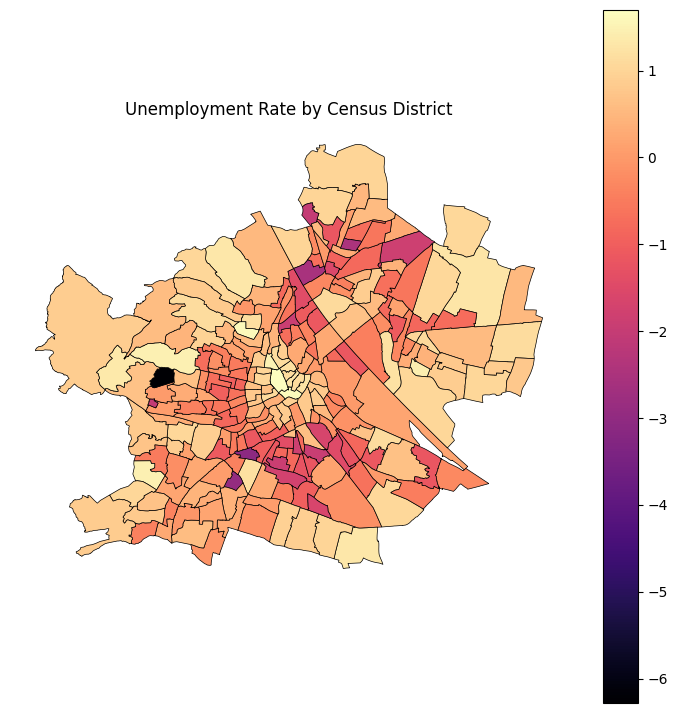

In [13]:
# Plot average income by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='unemprate',      
    cmap='magma',              
    linewidth=0.5,            
    edgecolor='black',        
    legend=True,              
    ax=ax
)

ax.set_title("Unemployment Rate by Census District", fontsize=12)
ax.axis('off')

plt.savefig("output/unemp_rate_map.png", dpi=300, bbox_inches='tight')
plt.show()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


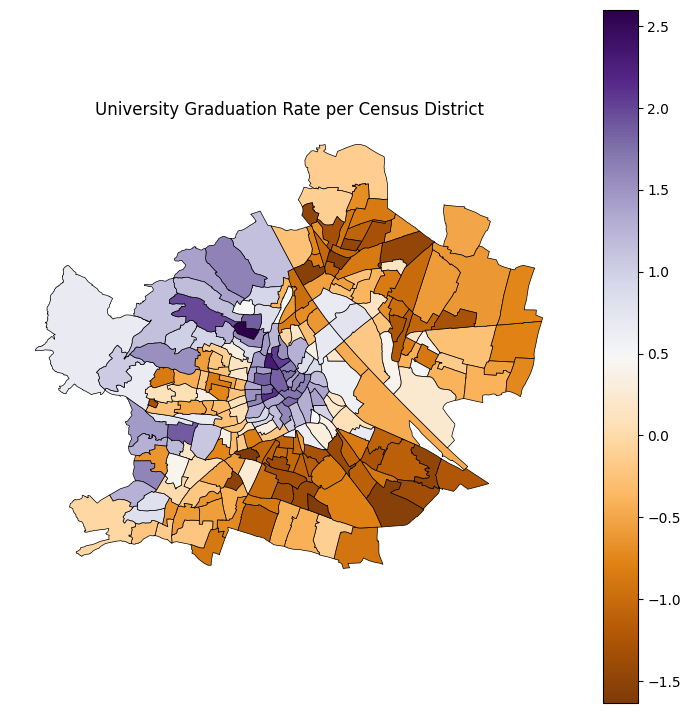

In [14]:
# Plot average income by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='university_share',     
    cmap='PuOr',              
    linewidth=0.5,            
    edgecolor='black',        
    legend=True,             
    ax=ax
)

ax.set_title("University Graduation Rate per Census District", fontsize=12)
ax.axis('off')

plt.savefig("output/uni_grad_rate_map.png", dpi=300, bbox_inches='tight')
plt.show()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


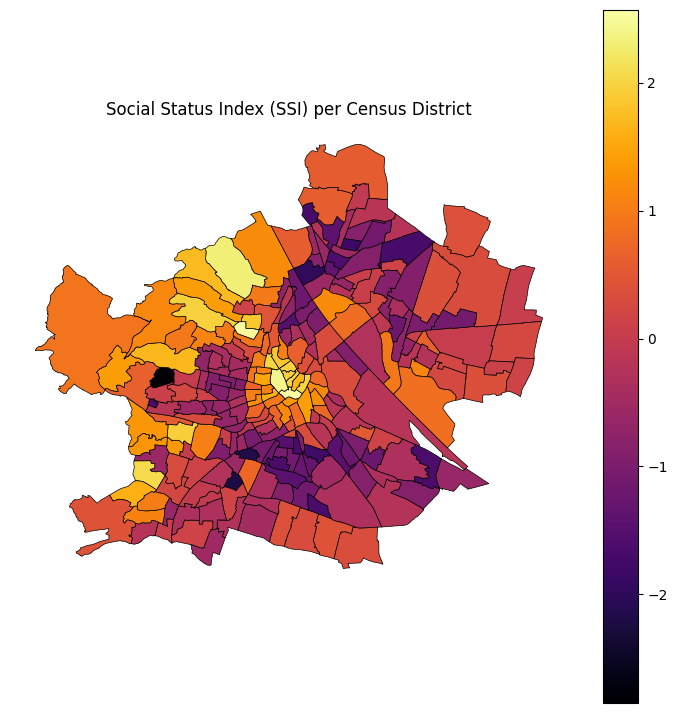

In [15]:
# Plot SSI by census district
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

gdf_census.plot(
    column='SSI',      
    cmap='inferno',              
    linewidth=0.5,           
    edgecolor='black',        
    legend=True,              
    ax=ax
)

ax.set_title("Social Status Index (SSI) per Census District", fontsize=12)
ax.axis('off')

plt.savefig("output/ssi_map.png", dpi=300, bbox_inches='tight')
plt.show()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


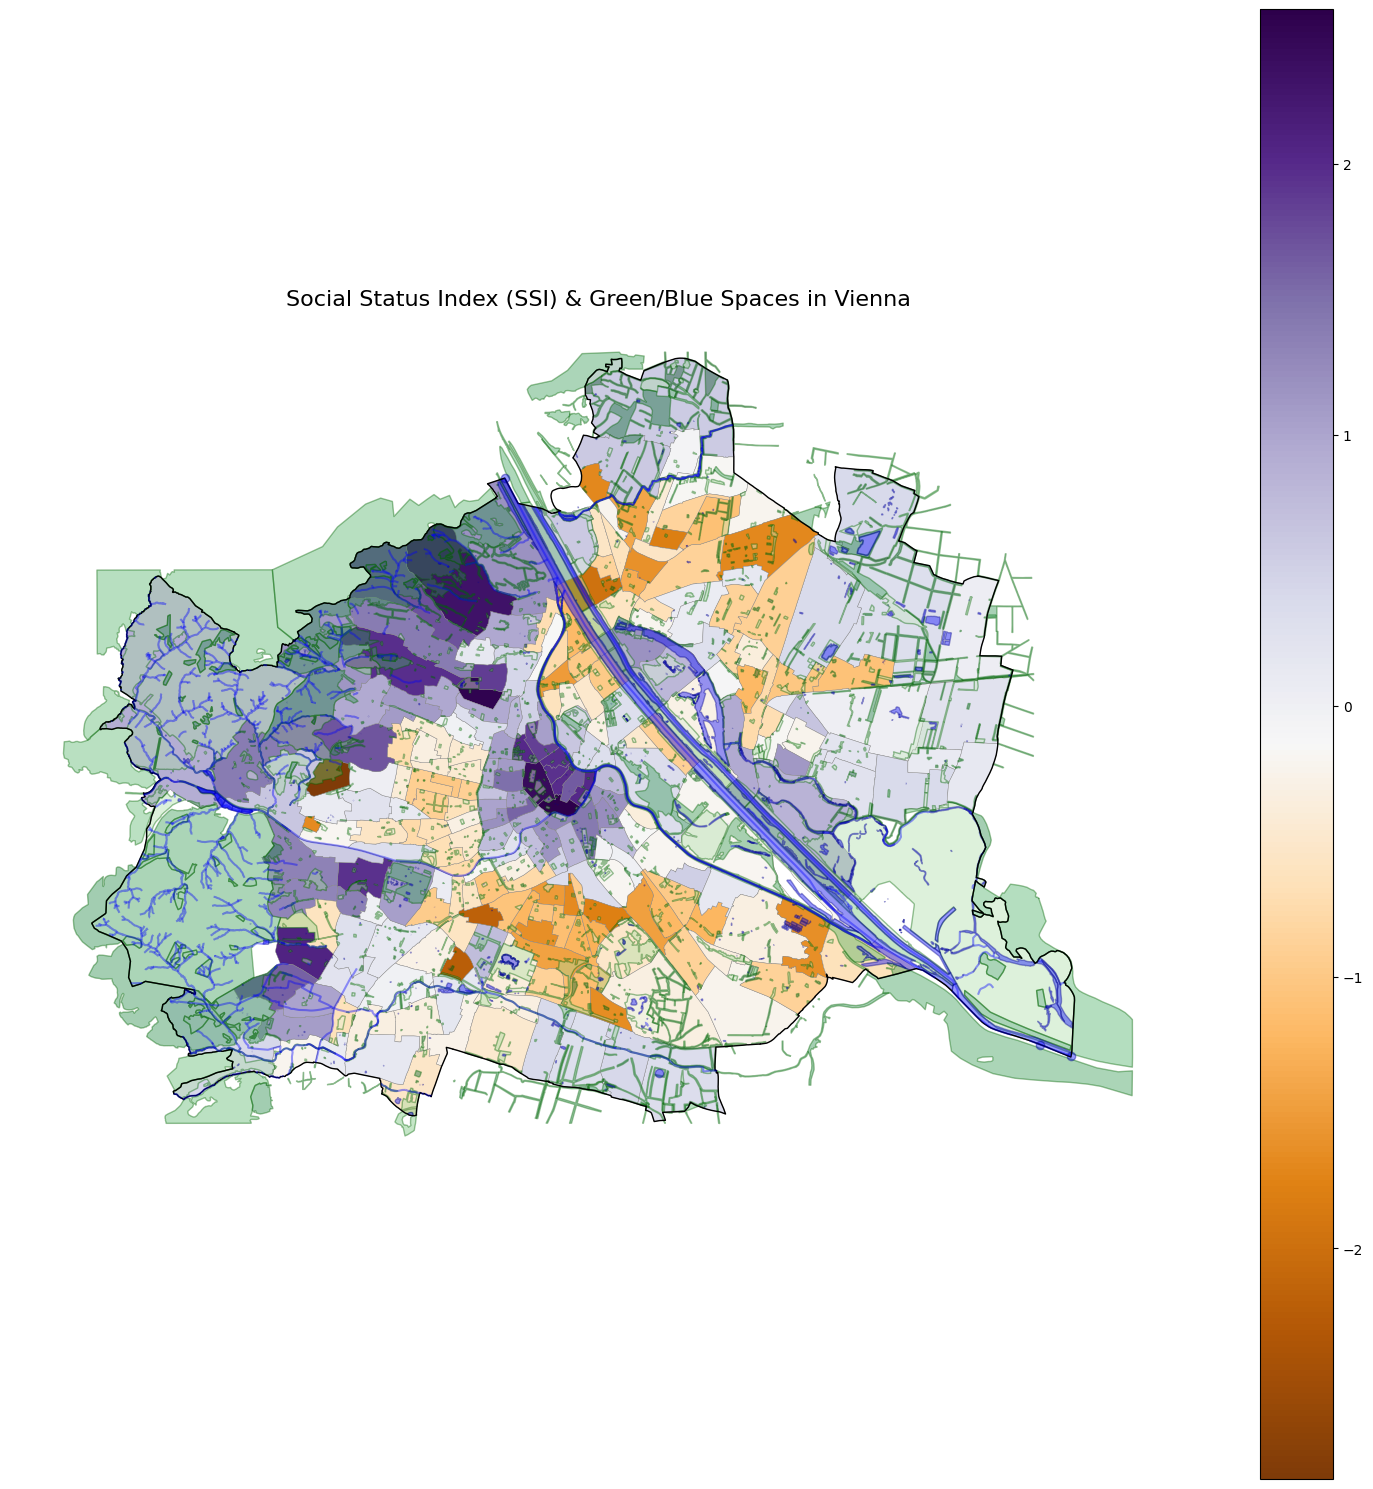

In [16]:
# Plot everything together
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot SSI as choropleth
gdf_census.plot(
    column='SSI',
    cmap='PuOr',     
    linewidth=0.3,
    edgecolor='gray',
    legend=True,
    ax=ax
)

# Overlay green and blue spaces
gdf_green.plot(ax=ax, cmap='Greens', alpha=0.4, edgecolor='darkgreen') #austrian governmental data
blue_clipped.plot(ax=ax, color='blue', alpha=0.4, edgecolor='darkblue') #OSM data

# Optional: plot city border
admin_city.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Tidy up
ax.set_title("Social Status Index (SSI) & Green/Blue Spaces in Vienna", fontsize=16)
ax.axis('off')

plt.tight_layout()

plt.savefig("output/ssi_ubgs_map.png", dpi=300, bbox_inches='tight')
plt.show()


## Correlation

* How much green/blue space overlap in each census district?
* Does the existence of green/blue spaces correlated with social status index (SSI)?

In [17]:
print(gdf_census.crs)
print(gdf_green.crs)
print(blue.crs)
print(admin_city.crs)

# epsg 4326 is coordinates, and not good for area and periphery calculations. 
# need to change their crs. Target crs: epsg=31256

gdf_census = gdf_census.to_crs(epsg=31256)
gdf_green = gdf_green.to_crs(epsg=31256)
admin_city = admin_city.to_crs(epsg=31256)
blue = blue.to_crs(epsg=31256)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


epsg:4326
epsg:4326
epsg:4326
epsg:4326


In [18]:
print(gdf_green.geometry.type.unique())
print(blue.geometry.type.unique())

# in order to overlay, I need same types of geometries
# seperate blue geometries into 2 different gdf: blue_lines, blue_areas

# Separate blue space geometries by type
blue_areas = blue[blue.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
blue_lines = blue[blue.geometry.type.isin(['LineString', 'MultiLineString'])].copy()

print(blue_areas.geometry.type.unique())
print(blue_lines.geometry.type.unique())

['MultiPolygon' 'Polygon']
['Point' 'Polygon' 'LineString' 'MultiPolygon']
['Polygon' 'MultiPolygon']
['LineString']


In [19]:
# green areas per district
green_clipped = gpd.clip(gdf_green, admin_city)
green_in_census = gpd.overlay(gdf_census, green_clipped, how='intersection', keep_geom_type=False)
green_in_census['green_area'] = green_in_census.geometry.area
green_area_by_district = green_in_census.groupby('ZBEZ')['green_area'].sum().reset_index()

In [20]:
# blue areas per district
blue_area_in_census = gpd.overlay(gdf_census, blue_areas, how='intersection')
blue_area_in_census['blue_area'] = blue_area_in_census.geometry.area
blue_area_by_district = blue_area_in_census.groupby('ZBEZ')['blue_area'].sum().reset_index()

# blue length per district
blue_lines_in_census = gpd.overlay(gdf_census, blue_lines, how='intersection', keep_geom_type=False)
blue_lines_in_census['blue_length'] = blue_lines_in_census.geometry.length
blue_length_by_district = blue_lines_in_census.groupby('ZBEZ')['blue_length'].sum().reset_index()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Merge green and blue components into census dataframe
gdf_census = gdf_census.merge(green_area_by_district, on='ZBEZ', how='left')
gdf_census = gdf_census.merge(blue_area_by_district, on='ZBEZ', how='left')
gdf_census = gdf_census.merge(blue_length_by_district, on='ZBEZ', how='left')

# Fill missing values (e.g., no green/blue areas or rivers) with 0
gdf_census[['green_area', 'blue_area', 'blue_length']] = gdf_census[[
    'green_area', 'blue_area', 'blue_length']].fillna(0)

gdf_census.head(3)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ZBEZ  university_share  avg_income  unemprate  benefit_share       SSI  \
0  0101          1.604954    1.741399   1.125923       1.123008  1.653992   
1  0102          1.653812    2.565233   1.237000       1.139440  2.000434   
2  0103          1.706598    3.805033   1.641029       1.232519  2.570582   

   quintile                                           geometry    green_area  \
0         5  POLYGON ((3485.019 341498.126, 3484.459 341498...   1176.751740   
1         5  POLYGON ((3487.789 341009.066, 3470.019 341017...  77668.038665   
2         5  POLYGON ((2735.149 340257.116, 2743.919 340257...  25070.979683   

      blue_area  blue_length  
0     16.971625     0.000000  
1  34107.715249  1181.722444  
2    135.225705  1090.379031

In [22]:
# Calculate district area in square kilometers (since CRS is in meters)
gdf_census['district_area_km2'] = gdf_census.geometry.area / 1e6

# Normalize each variable by district size
gdf_census['green_ratio'] = gdf_census['green_area'] / gdf_census['district_area_km2']
gdf_census['blue_area_ratio'] = gdf_census['blue_area'] / gdf_census['district_area_km2']
gdf_census['blue_length_km'] = gdf_census['blue_length'] / 1000  # optional, km of river

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#COMMENT FOR FUTURE: DO IT BY EXCLUDING INNERE STADT. IT HAS HIGH SSI, BUT HISTROICAL BUILDINGS LESS UBGS
# Correlation matrix
corr_matrix = gdf_census[['SSI', 'green_ratio', 'blue_area_ratio', 'blue_length_km']].corr()
print(corr_matrix)

                      SSI  green_ratio  blue_area_ratio  blue_length_km
SSI              1.000000     0.204862        -0.053523        0.163702
green_ratio      0.204862     1.000000         0.308180        0.638585
blue_area_ratio -0.053523     0.308180         1.000000        0.138026
blue_length_km   0.163702     0.638585         0.138026        1.000000


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
import statsmodels.api as sm

# Prepare data
X = gdf_census[['university_share', 'avg_income', 'unemprate', 'benefit_share', 'green_ratio', 'blue_area_ratio', 'blue_length_km']]
X = sm.add_constant(X)  # adds intercept term
A = gdf_census[['university_share', 'avg_income', 'unemprate', 'benefit_share']]
A = sm.add_constant(A)  # adds intercept term
B = gdf_census[['green_ratio', 'blue_area_ratio', 'blue_length_km']]
B = sm.add_constant(B)  # adds intercept term
y = gdf_census['SSI']

# Fit model
model = sm.OLS(y, X).fit()
model2 =sm.OLS(y, A).fit()
model3 =sm.OLS(y, B).fit()
print(model.summary())
print(model2.summary())
print(model3.summary())

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                            OLS Regression Results                            
Dep. Variable:                    SSI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.979e+24
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:07:34   Log-Likelihood:                 6098.9
No. Observations:                 246   AIC:                        -1.218e+04
Df Residuals:                     238   BIC:                        -1.215e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             9.425e-13   3.61e-13  

In [25]:
# Prepare data
X = gdf_census['SSI']
X = sm.add_constant(X)  # adds intercept term
y = gdf_census[['green_ratio']]

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            green_ratio   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     10.69
Date:                Wed, 16 Apr 2025   Prob (F-statistic):            0.00123
Time:                        22:07:34   Log-Likelihood:                -3260.6
No. Observations:                 246   AIC:                             6525.
Df Residuals:                     244   BIC:                             6532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.088e+05   8839.373     12.307      0.0

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Introduction of housing data into the analysis

* Data is from Statistiks Austria. 
* Does the existence of green/blue spaces affect the housing prices in that district?
* If they affect, can we check how it changes with proximity of housing to green/blue space?

In [26]:
# !pip install odfpy pandas
# Load ODS file and list all sheet names
housing_path = "data/SpecialEvaluation.ods" 
housing_data = pd.read_excel(housing_path, engine="odf", sheet_name=None)

# Show available sheets
print(housing_data.keys())

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['Apartment_Prices', 'House_Prices', 'Building_Plots', 'Federal_Provinces', 'Apartment_Prices_municipalities', 'House_Prices_municipalities', 'Fed__states_and_constr__Periods'])


In [27]:
housing_data = pd.read_excel(
    housing_path,
    engine="odf",
    sheet_name="Apartment_Prices",  
    header=1                        # use row 2 as column names
)
housing_data.columns

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['D. CD.', 'Districts', 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023],
      dtype='object')

In [28]:
# Keep only Vienna rows
housing_vienna = housing_data[
    housing_data['Districts'].str.contains('Wien', na=False) &
    ~housing_data['Districts'].str.contains('Wiener Neustadt', na=False)
]
housing_vienna.columns = housing_vienna.columns.astype(str)

housing_vienna.loc[:, 'district_clean'] = housing_vienna['Districts'].str.split(',').str[1].str.strip()
housing_vienna.head(3)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-fad94a8a7aa3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_vienna.loc[:, 'district_clean'] = housing_vienna['Districts'].str.split(',').str[1].str.strip()


D. CD.              Districts  2015  2016  2017   2018   2019   2020  \
93    901  Wien  1.,Innere Stadt  6569  7861  9368  10955  11186  10947   
94    902  Wien  2.,Leopoldstadt  3650  4125  4327   4482   4590   5215   
95    903    Wien  3.,Landstraße  3934  4039  4483   4787   4375   5483   

     2021   2022   2023 district_clean  
93  13078  14389  12733   Innere Stadt  
94   5331   6181   5494   Leopoldstadt  
95   5715   5850   5635     Landstraße

In [29]:
districts = gpd.read_file('data/vienna_districts.geojson') # districts data from GIS course hw2
districts.head(3)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NAMEK  BEZNR BEZ_RZ                  NAMEK_NUM  \
0              Hietzing   13.0   XIII              13., Hietzing   
1  Rudolfsheim-Fünfhaus   15.0     XV  15., Rudolfsheim-Fünfhaus   
2                Neubau    7.0    VII                 7., Neubau   

                   NAMEK_RZ                 NAMEG  LABEL BEZ  DISTRICT_C  \
0            XIII. Hietzing              HIETZING  XIII.  13      1130.0   
1  XV. Rudolfsheim-Fünfhaus  RUDOLFSHEIM-FÜNFHAUS    XV.  15      1150.0   
2               VII. Neubau                NEUBAU   VII.  07      1070.0   

   STATAUSTRI  STATAUSTR0       FLAECHE    UMFANG AKT_TIMEST  SE_SDO_ROW  \
0       913.0     91301.0  3.771397e+07  29668.16 2023-07-18     13126.0   
1       915.0     91501.0  3.916953e+06   9711.71 2023-07-18     13127.0   
2       907.0     90701.0  1.608248e+06   5312.54 2023-07-18     13128.0   

                                            geometry  
0  POLYGON ((16.21423 48.20652, 16.21425 48.20651...  
1  POLYGON ((16.32732 48.20500, 16.33366 48.20406...  
2  POLYGON ((16.33873 48.20854, 16.33901 48.20849...

In [30]:
# Merging housing prices data into districts GeoDataFrame
housing_districts = districts.merge(
    housing_vienna[['district_clean', '2015', '2016', '2017', '2018', '2019', '2020',  '2021', '2022', '2023']],
    left_on='NAMEK',
    right_on='district_clean',
    how='left'
)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
housing_districts.columns 

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['NAMEK', 'BEZNR', 'BEZ_RZ', 'NAMEK_NUM', 'NAMEK_RZ', 'NAMEG', 'LABEL',
       'BEZ', 'DISTRICT_C', 'STATAUSTRI', 'STATAUSTR0', 'FLAECHE', 'UMFANG',
       'AKT_TIMEST', 'SE_SDO_ROW', 'geometry', 'district_clean', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'],
      dtype='object')

c:\Users\yakus\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


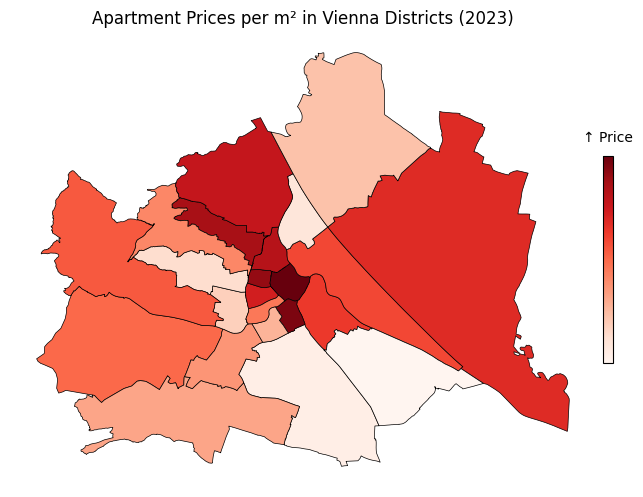

In [32]:
fig, ax = plt.subplots(figsize=(9, 9))

# Plot without legend
housing_districts_plot = housing_districts.plot(
    column='2023',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend=False 
)

# Create a scalar mappable for the colorbar
norm = mpl.colors.Normalize(
    vmin=housing_districts['2023'].min(),
    vmax=housing_districts['2023'].max()
)
sm = mpl.cm.ScalarMappable(cmap='Reds', norm=norm)
sm._A = []  # required for matplotlib <3.1

# Adding the colorbar manually
cbar = fig.colorbar(
    sm,
    ax=ax,
    shrink=0.3,              
    pad=0.01,                
    orientation='vertical',
    location='right'         
)

# Remove ticks and add title to the colorbar
cbar.ax.set_yticks([])
cbar.ax.set_title('↑ Price', fontsize=10, pad=10)

# Final plot tweaks
ax.set_title("Apartment Prices per m² in Vienna Districts (2023)", fontsize=12)
ax.axis('off')
plt.show()

In [33]:
green_clipped = green_clipped.to_crs(districts.crs)
blue_clipped = blue_clipped.to_crs(districts.crs)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\Users\yakus\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


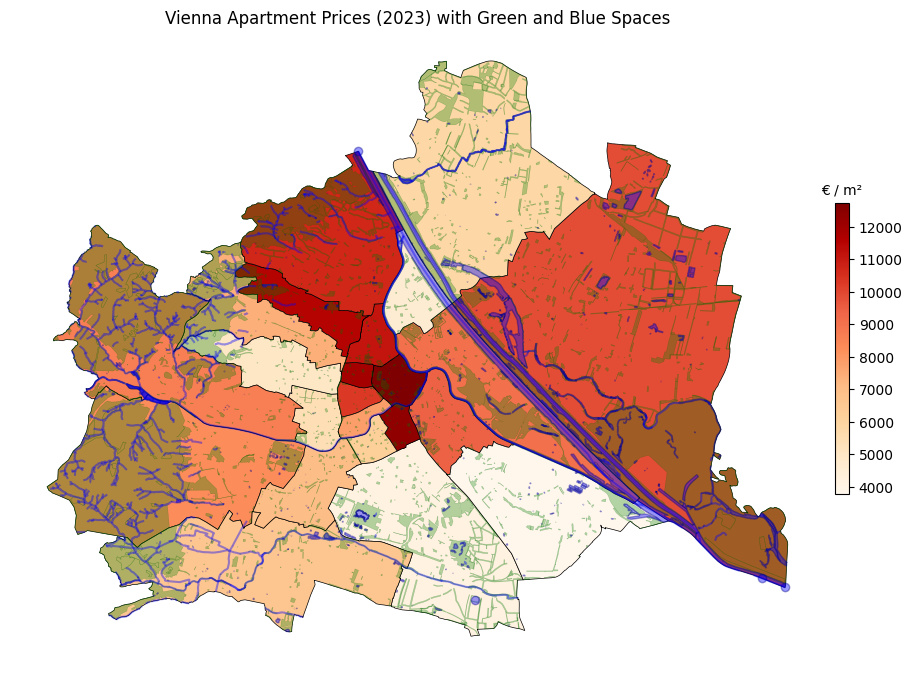

In [34]:
# Setup plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot housing prices as base choropleth
housing_districts.plot(
    column='2023',
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend=False  
)

# Overlay green and blue spaces
green_clipped.plot(ax=ax, color='green', alpha=0.3, edgecolor='darkgreen', linewidth=0.3)
blue_clipped.plot(ax=ax, color='blue', alpha=0.4, edgecolor='darkblue')

# Add colorbar manually
norm = mpl.colors.Normalize(vmin=housing_districts['2023'].min(), vmax=housing_districts['2023'].max())
sm = mpl.cm.ScalarMappable(cmap='OrRd', norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.3, pad=0.01)
cbar.ax.set_title('€ / m²', fontsize=10)

# Title & layout
ax.set_title("Vienna Apartment Prices (2023) with Green and Blue Spaces", fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.show()


## Correlation of housing prices with UBGS

* Is there a correlation between the amount of green/blue spaces in districts and their average housing price per m2?

In [35]:
print(gdf_census.crs)
print(housing_districts.crs)

epsg:31256
epsg:4326


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
housing_districts = housing_districts.to_crs(gdf_census.crs)
print(housing_districts.crs)

epsg:31256


In [37]:
census_with_district = gpd.sjoin(
    gdf_census,
    housing_districts[['district_clean', 'geometry']],  # keep only name + geometry of Bezirke
    how='left',
    predicate='intersects'
)

In [38]:
census_with_district.head(3)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ZBEZ  university_share  avg_income  unemprate  benefit_share       SSI  \
0  0101          1.604954    1.741399   1.125923       1.123008  1.653992   
0  0101          1.604954    1.741399   1.125923       1.123008  1.653992   
1  0102          1.653812    2.565233   1.237000       1.139440  2.000434   

   quintile                                           geometry    green_area  \
0         5  POLYGON ((3485.019 341498.126, 3484.459 341498...   1176.751740   
0         5  POLYGON ((3485.019 341498.126, 3484.459 341498...   1176.751740   
1         5  POLYGON ((3487.789 341009.066, 3470.019 341017...  77668.038665   

      blue_area  blue_length  district_area_km2    green_ratio  \
0     16.971625     0.000000           0.377557    3116.750799   
0     16.971625     0.000000           0.377557    3116.750799   
1  34107.715249  1181.722444           0.379377  204725.351201   

   blue_area_ratio  blue_length_km  index_right district_clean  
0        44.951134        0.000000            8   Leopoldstadt  
0        44.951134        0.000000            5   Innere Stadt  
1     89904.600437        1.181722            3     Landstraße

In [39]:
# Aggregate total green/blue values per main district
green_blue_summary = census_with_district.groupby('district_clean')[
    ['green_ratio', 'blue_area_ratio', 'blue_length_km']
].sum().reset_index()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# Merge green/blue summary into housing districts
districts_full = housing_districts.merge(
    green_blue_summary,
    on='district_clean',
    how='left'
)

print(districts_full.columns)
districts_full.head(3)

Index(['NAMEK', 'BEZNR', 'BEZ_RZ', 'NAMEK_NUM', 'NAMEK_RZ', 'NAMEG', 'LABEL',
       'BEZ', 'DISTRICT_C', 'STATAUSTRI', 'STATAUSTR0', 'FLAECHE', 'UMFANG',
       'AKT_TIMEST', 'SE_SDO_ROW', 'geometry', 'district_clean', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023',
       'green_ratio', 'blue_area_ratio', 'blue_length_km'],
      dtype='object')


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NAMEK  BEZNR BEZ_RZ                  NAMEK_NUM  \
0              Hietzing   13.0   XIII              13., Hietzing   
1  Rudolfsheim-Fünfhaus   15.0     XV  15., Rudolfsheim-Fünfhaus   
2                Neubau    7.0    VII                 7., Neubau   

                   NAMEK_RZ                 NAMEG  LABEL BEZ  DISTRICT_C  \
0            XIII. Hietzing              HIETZING  XIII.  13      1130.0   
1  XV. Rudolfsheim-Fünfhaus  RUDOLFSHEIM-FÜNFHAUS    XV.  15      1150.0   
2               VII. Neubau                NEUBAU   VII.  07      1070.0   

   STATAUSTRI  ...  2017  2018  2019  2020  2021  2022  2023   green_ratio  \
0       913.0  ...  4043  4423  4462  4821  5593  6159  5327  3.993495e+06   
1       915.0  ...  3315  3827  3860  4111  4729  4460  4215  8.704137e+05   
2       907.0  ...  4755  5405  5833  6043  6332  6336  5929  8.574807e+05   

  blue_area_ratio blue_length_km  
0    37268.759074      97.913336  
1      658.385414       5.912850  
2     1802.907165       2.143164  

[3 rows x 29 columns]

In [41]:
# Correlation matrix
districts_full[['2023', 'green_ratio', 'blue_area_ratio', 'blue_length_km']].corr()

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


green_ratio  blue_area_ratio  blue_length_km
green_ratio         1.000000         0.602164        0.668834
blue_area_ratio     0.602164         1.000000        0.056649
blue_length_km      0.668834         0.056649        1.000000

In [42]:
import statsmodels.api as sm

ubgs = districts_full[['green_ratio', 'blue_area_ratio', 'blue_length_km']]
ubgs = sm.add_constant(ubgs)  
price = districts_full['2023']

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
print(ubgs.dtypes)

const              float64
green_ratio        float64
blue_area_ratio    float64
blue_length_km     float64
dtype: object


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Convert all columns to numeric (force errors to NaN)
ubgs = ubgs.apply(pd.to_numeric, errors='coerce')
price = pd.to_numeric(price, errors='coerce')

print(ubgs.isna().sum())   # NaNs in predictors
print(price.isna().sum())  # NaNs in outcome variable

const              0
green_ratio        0
blue_area_ratio    0
blue_length_km     0
dtype: int64
0


In [45]:
model = sm.OLS(price, ubgs).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   2023   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.129
Method:                 Least Squares   F-statistic:                    0.1627
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.920
Time:                        22:07:39   Log-Likelihood:                -204.08
No. Observations:                  23   AIC:                             416.2
Df Residuals:                      19   BIC:                             420.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5840.7097    937.749     

# WHO theory

In [46]:
# all residential buildings
residential_tags = {'building': ['residential', 'apartments', 'house', 'detached', 'terrace']}
residential = ox.features_from_place('Vienna, Austria', tags=residential_tags)

print("Number of residential buildings:", len(residential))
residential.head(5)

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of residential buildings: 66085


entrance                   geometry addr:unit  \
element_type osmid                                                      
node         3050128807      NaN  POINT (16.45262 48.24040)       NaN   
             3191378969      NaN  POINT (16.28469 48.18459)       NaN   
             3191378970      NaN  POINT (16.28475 48.18473)       NaN   
             3220013168      NaN  POINT (16.47623 48.21350)       NaN   
             3220013171      NaN  POINT (16.47638 48.21381)       NaN   

                        addr:city addr:country addr:housenumber addr:postcode  \
element_type osmid                                                              
node         3050128807      Wien           AT              NaN          1220   
             3191378969      Wien           AT               39          1130   
             3191378970      Wien           AT               41          1130   
             3220013168      Wien           AT              7/5          1220   
             3220013171      Wien           AT              7/1          1220   

                                addr:street amenity created_by  ... community  \
element_type osmid                                              ...             
node         3050128807       Pogrelzstraße     NaN        NaN  ...       NaN   
             3191378969  Münichreiterstraße     NaN        NaN  ...       NaN   
             3191378970  Münichreiterstraße     NaN        NaN  ...       NaN   
             3220013168      Stavangergasse     NaN        NaN  ...       NaN   
             3220013171      Stavangergasse     NaN        NaN  ...       NaN   

                        community:de community:en community:fr  \
element_type osmid                                               
node         3050128807          NaN          NaN          NaN   
             3191378969          NaN          NaN          NaN   
             3191378970          NaN          NaN          NaN   
             3220013168          NaN          NaN          NaN   
             3220013171          NaN          NaN          NaN   

                        community:gender community:it roof:type former:name  \
element_type osmid                                                            
node         3050128807              NaN          NaN       NaN         NaN   
             3191378969              NaN          NaN       NaN         NaN   
             3191378970              NaN          NaN       NaN         NaN   
             3220013168              NaN          NaN       NaN         NaN   
             3220013171              NaN          NaN       NaN         NaN   

                        building:height addr:interpolation  
element_type osmid                                          
node         3050128807             NaN                NaN  
             3191378969             NaN                NaN  
             3191378970             NaN                NaN  
             3220013168             NaN                NaN  
             3220013171             NaN                NaN  

[5 rows x 252 columns]

Check the general statistics and the percentage of compliant buildings based on the WHO guideline

In [47]:
# City-wide Vienna boundary from districts
vienna_boundary = districts.unary_union
vienna_gdf = gpd.GeoDataFrame(geometry=[vienna_boundary], crs=districts.crs)

# Clean geometry and reproject everything to a common projected CRS (EPSG:31256)
residential = residential[residential.is_valid & ~residential.is_empty]
gdf_green = gdf_green[gdf_green.is_valid & ~gdf_green.is_empty]

crs_proj = 31256
vienna_gdf_proj = vienna_gdf.to_crs(epsg=crs_proj)
residential_proj = residential.to_crs(epsg=crs_proj)
green_proj = gdf_green.to_crs(epsg=crs_proj)

# Clip residential and green areas to Vienna boundary
residential_vienna = gpd.clip(residential_proj, vienna_gdf_proj)
green_vienna = gpd.clip(green_proj, vienna_gdf_proj)

# Calculate centroids of residential buildings
res_centroids = residential_vienna.copy()
res_centroids['geometry'] = res_centroids.centroid

# Calculate distances to nearest green space
green_union = unary_union(green_vienna.geometry)
res_centroids['distance_to_green'] = res_centroids.geometry.apply(lambda x: x.distance(green_union))
res_centroids['within_300m'] = res_centroids['distance_to_green'] <= 300

# Output stats
total = len(res_centroids)
within = res_centroids['within_300m'].sum()
percent = (within / total) * 100 if total > 0 else 0

print("WHO 300m Rule for Vienna:")
print(f"Total residential buildings: {total}")
print(f"Within 300m of green space: {within}")
print(f"Percentage compliant with WHO guideline: {percent:.2f}%")

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WHO 300m Rule for Vienna:
Total residential buildings: 66085
Within 300m of green space: 62173
Percentage compliant with WHO guideline: 94.08%


Plot the non-compliant buildings for the whole city

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


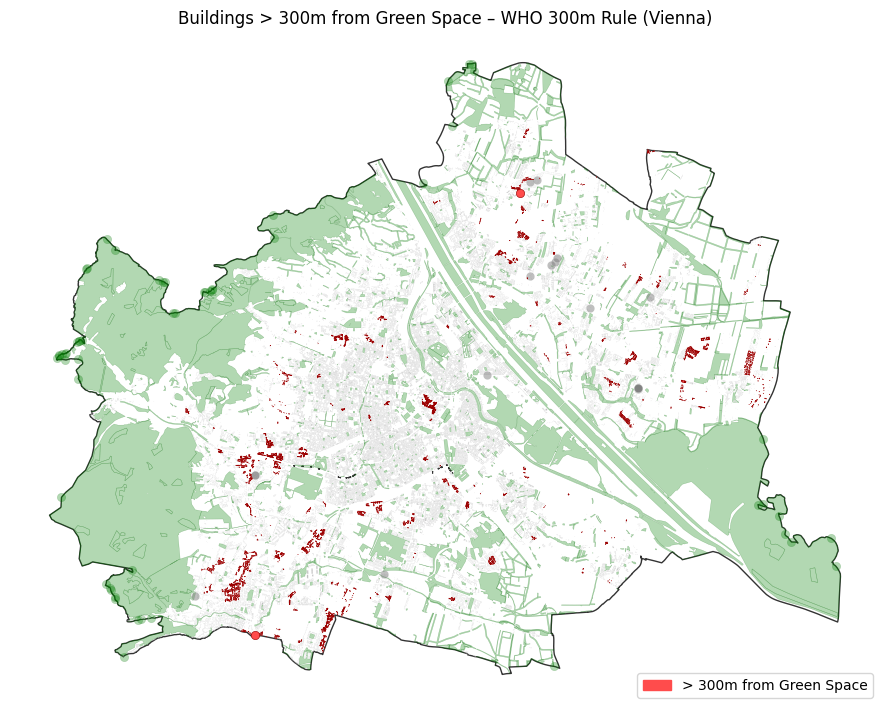

In [ ]:

# Clip green areas to Vienna for clean plot
green_clipped = gpd.clip(green_proj, vienna_gdf_proj)

# Get non-compliant buildings
non_compliant_buildings = residential_vienna[~res_centroids['within_300m'].values]

# Create the plot
fig, ax = plt.subplots(figsize=(9, 9))

# Plot layers
vienna_gdf_proj.plot(ax=ax, color='none', edgecolor='#333333')  # Outline
green_clipped.plot(ax=ax, color='green', alpha=0.3, edgecolor='darkgreen', linewidth=0.3)  # Green areas
residential_vienna.plot(ax=ax, color='grey', alpha=0.5, edgecolor='white', linewidth=0.2) # Residential buildings
non_compliant_buildings.plot(ax=ax, color='#FF4C4C', edgecolor='#990000', linewidth=0.4)  # Non-compliant

# Legend
legend_patch = mpatches.Patch(color='#FF4C4C', label='> 300m from Green Space')
plt.legend(handles=[legend_patch], loc='lower right')

# Title and export
plt.title("Buildings > 300m from Green Space – WHO 300m Rule (Vienna)", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.savefig("output/vienna_who_300m_noncompliant_only_legend.png", dpi=300, bbox_inches='tight')
plt.show()

Plot non-compliant buildings using hexagons for better spatial understanding

In [49]:
def split_poly_to_hexagons(admin_gdf, resolution, crs):
    
    coords = list(admin_gdf.geometry.to_list()[0].exterior.coords)
    admin_geojson = {"type": "Polygon",  "coordinates": [coords]}
    hexagons = h3.polyfill(admin_geojson, 
                           resolution, 
                           geo_json_conformant=True)
    
    hexagon_geometries = {hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, \
                                geo_json=True)) for hex_id in hexagons}
    gdf_hexagon_geometries = gpd.GeoDataFrame(hexagon_geometries.items(), 
                                    columns=['hex_id', 'geometry'])
    gdf_hexagon_geometries.crs = crs
    
    return gdf_hexagon_geometries

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


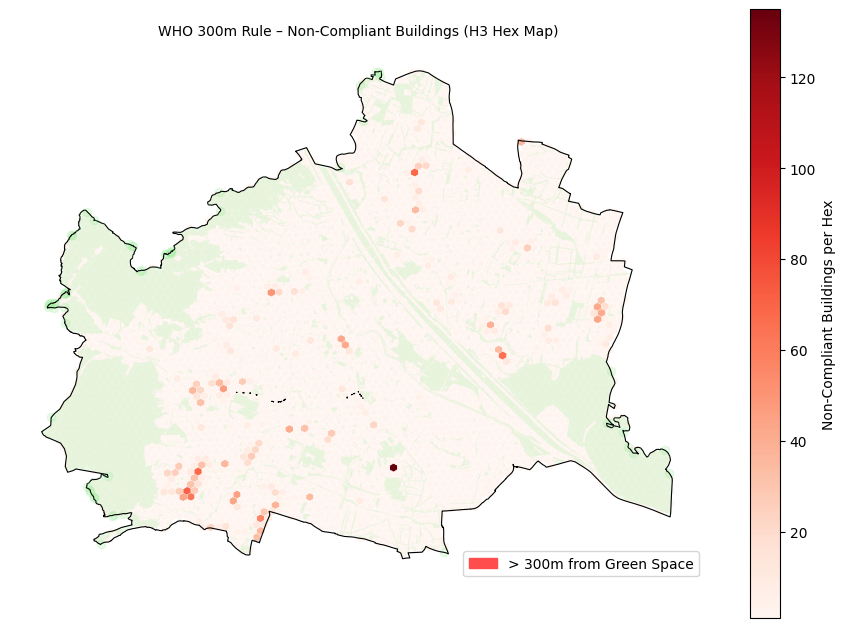

In [50]:
# Generate H3 hexagons for Vienna
vienna_proj = vienna_gdf.to_crs(epsg=4326)
hex_gdf = split_poly_to_hexagons(vienna_proj, resolution=9, crs="EPSG:4326")

# Reproject hexes and non-compliant buildings
hex_gdf_proj = hex_gdf.to_crs(epsg=31256)
noncompliant_proj = residential_vienna[~res_centroids['within_300m'].values]
noncompliant_proj = noncompliant_proj.to_crs(epsg=31256)

# Spatial join – assign buildings to H3 hexagons
join_hex = gpd.sjoin(hex_gdf_proj, noncompliant_proj, how="left", predicate="contains")

# Count buildings per hex
counts = join_hex.groupby('hex_id').size()
hex_gdf_proj['noncompliant_count'] = hex_gdf_proj['hex_id'].map(counts).fillna(0)

fig, ax = plt.subplots(figsize=(9, 9))
hex_gdf_proj.plot(
    ax=ax,
    column='noncompliant_count',
    cmap='Reds',
    edgecolor='white',
    linewidth=0.2,
    legend=True,
    legend_kwds={'label': 'Non-Compliant Buildings per Hex', 'shrink': 0.7}
)
green_clipped = gpd.clip(green_proj, vienna_gdf_proj)
green_clipped.plot(ax=ax, color='#90EE90', alpha=0.2)
vienna_gdf_proj.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8)

red_patch = mpatches.Patch(color='#FF4C4C', label='> 300m from Green Space')
plt.legend(handles=[red_patch], loc='lower right')

plt.title('WHO 300m Rule – Non-Compliant Buildings (H3 Hex Map)', fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.savefig('output/vienna_noncompliant_h3_hexmap.png', dpi=300, bbox_inches='tight')
plt.show()

Calculate each district’s scaled contribution to Vienna’s total non-compliant buildings

In [51]:
# Spatial join to assign each building to its district
districts_proj = districts.to_crs(epsg=31256)
res_with_district = gpd.sjoin(res_centroids, districts_proj[['NAMEK', 'geometry']], how='left', predicate='within')

# Group by district and summarize WHO compliance
district_summary = (
    res_with_district
    .groupby('NAMEK')
    .agg(
        total_buildings=('within_300m', 'count'),
        compliant_buildings=('within_300m', 'sum')
    )
    .assign(percent_compliant=lambda df: 100 * df['compliant_buildings'] / df['total_buildings'])
    .sort_values(by='percent_compliant', ascending=False)
)


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Citywide non-compliance rate: 5.92%


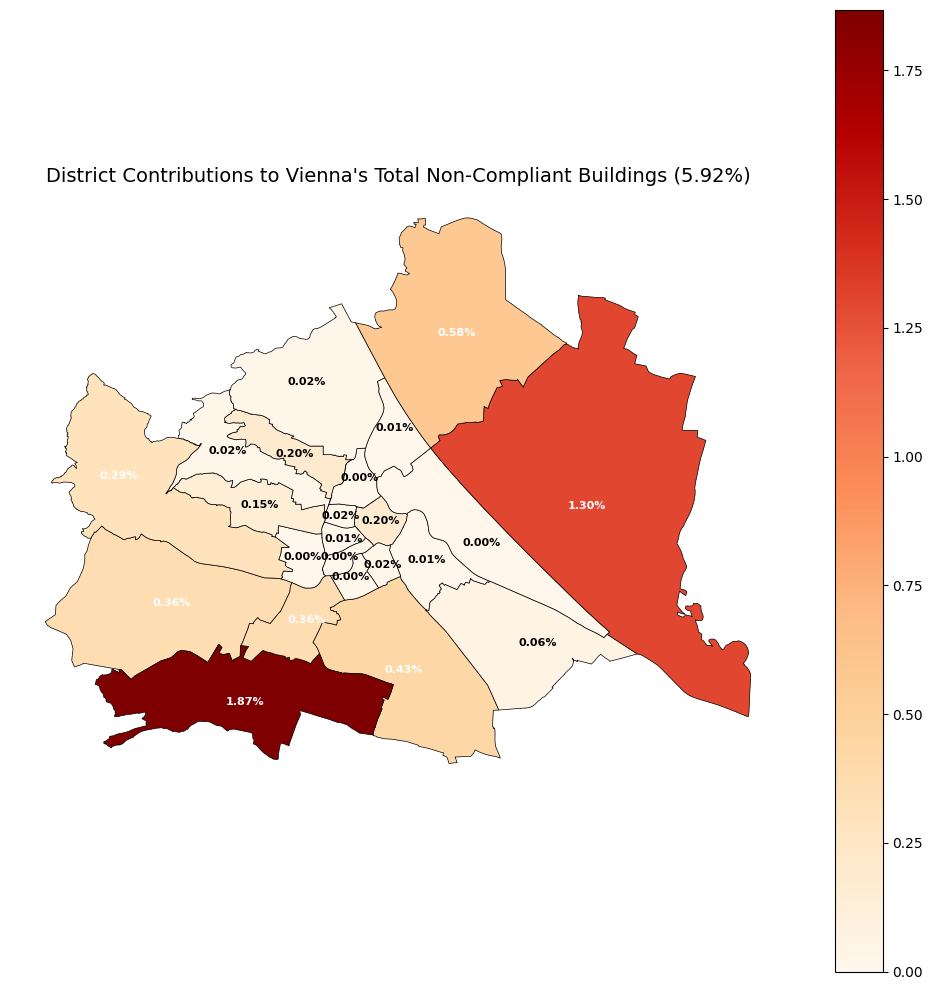

In [52]:
# Reset and calculate district-level non-compliance
district_summary = district_summary.reset_index()
district_summary['noncompliant_buildings'] = (
    district_summary['total_buildings'] - district_summary['compliant_buildings']
)

# Calculate citywide non-compliance percent
citywide_total = district_summary['total_buildings'].sum()
citywide_compliant = district_summary['compliant_buildings'].sum()
citywide_noncompliant = citywide_total - citywide_compliant
citywide_noncompliance_percent = (citywide_noncompliant / citywide_total) * 100
print(f"Citywide non-compliance rate: {citywide_noncompliance_percent:.2f}%")

# Scale district values to match citywide % total
district_summary['noncompliant_share_scaled'] = (
    district_summary['noncompliant_buildings'] / citywide_noncompliant * citywide_noncompliance_percent
)

# Merge with spatial data
districts_cityshare = districts.merge(
    district_summary[['NAMEK', 'noncompliant_share_scaled']], on='NAMEK'
)
districts_cityshare = districts_cityshare.to_crs(epsg=31256)


fig, ax = plt.subplots(figsize=(10, 10))
districts_cityshare.plot(
    ax=ax,
    column='noncompliant_share_scaled',
    cmap='OrRd',
    legend=True,
    edgecolor='black',
    linewidth=0.5
)

districts_cityshare['label_point'] = districts_cityshare.representative_point()
for _, row in districts_cityshare.iterrows():
    ax.text(
        row['label_point'].x,
        row['label_point'].y,
        f"{row['noncompliant_share_scaled']:.2f}%",
        fontsize=8,
        ha='center',
        va='center',
        color='black' if row['noncompliant_share_scaled'] < 0.2 else 'white',
        weight='bold'
    )

plt.title(f"District Contributions to Vienna's Total Non-Compliant Buildings ({citywide_noncompliance_percent:.2f}%)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("output/vienna_noncompliance_contribution_scaled_map.png", dpi=300, bbox_inches='tight')
plt.show()


Do the same but within districts

In [53]:
# Calculate non-compliance % within each district
district_summary['percent_noncompliant'] = 100 - district_summary['percent_compliant']
district_summary = district_summary.reset_index()  # Make NAMEK a column

c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


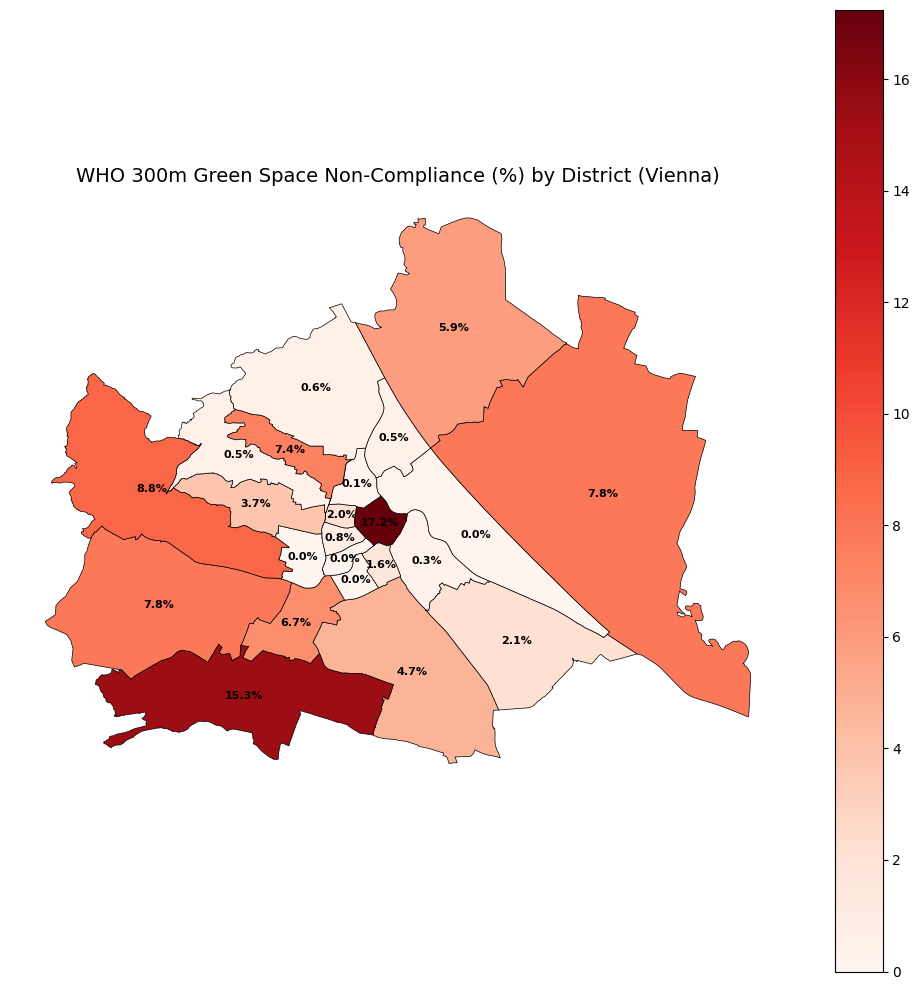

In [54]:
# Merge with districts GeoDataFrame
districts_plot = districts.merge(district_summary, on='NAMEK')
districts_plot = districts_plot.to_crs(epsg=31256)

# Get label positions (centroids)
districts_plot['centroid'] = districts_plot.geometry.centroid
districts_plot['label_x'] = districts_plot.centroid.x
districts_plot['label_y'] = districts_plot.centroid.y

fig, ax = plt.subplots(figsize=(10, 10))
districts_plot.plot(
    ax=ax,
    column='percent_noncompliant',
    cmap='Reds',
    legend=True,
    edgecolor='black',
    linewidth=0.5
)

for idx, row in districts_plot.iterrows():
    ax.text(
        row['label_x'],
        row['label_y'],
        f"{row['percent_noncompliant']:.1f}%",
        fontsize=8,
        ha='center',
        va='center',
        color='black' if row['percent_noncompliant'] < 50 else 'white',
        weight='bold'
    )

plt.title("WHO 300m Green Space Non-Compliance (%) by District (Vienna)", fontsize=14)
plt.axis('off')
plt.tight_layout()

plt.savefig("output/vienna_who_noncompliance_labeled_map.png", dpi=300, bbox_inches='tight')
plt.show()


Generates individual maps for all districts with non-compliant buildings, showing which residential buildings exceed the WHO 300m green space threshold.

In [ ]:
# Build target_districts from previous summary
# Only districts with at least one non-compliant building
noncompliant_districts = district_summary[district_summary['noncompliant_buildings'] > 0]

# Generate dynamic district list: {index: name}
target_districts = {i + 1: name for i, name in enumerate(noncompliant_districts['NAMEK'])}
print("Target districts with non-compliant buildings:", target_districts)

Target districts with non-compliant buildings: {1: 'Alsergrund', 2: 'Landstraße', 3: 'Brigittenau', 4: 'Hernals', 5: 'Döbling', 6: 'Neubau', 7: 'Wieden', 8: 'Josefstadt', 9: 'Simmering', 10: 'Ottakring', 11: 'Favoriten', 12: 'Floridsdorf', 13: 'Meidling', 14: 'Währing', 15: 'Donaustadt', 16: 'Hietzing', 17: 'Penzing', 18: 'Liesing', 19: 'Innere Stadt'}


c:\Users\yakus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 Processing District: Alsergrund
Total buildings: 1131
Within 300m: 1125
Compliant: 99.47%


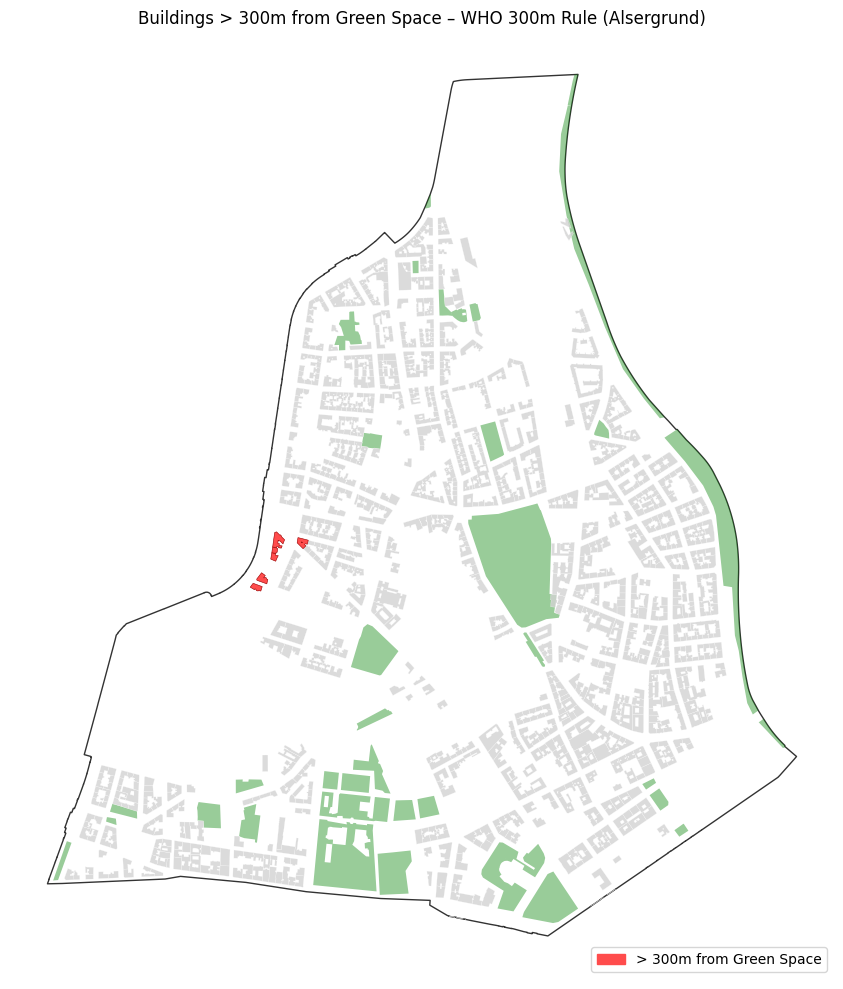


 Processing District: Landstraße
Total buildings: 2482
Within 300m: 2474
Compliant: 99.68%


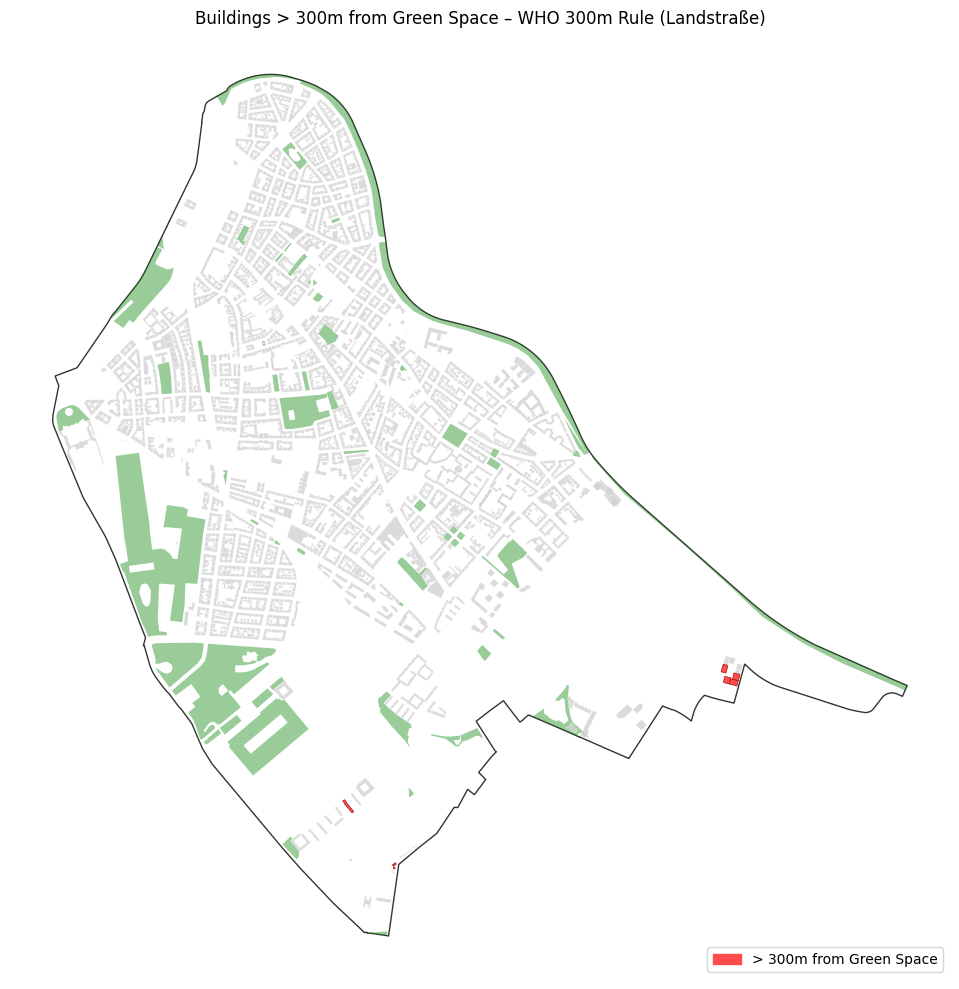


 Processing District: Brigittenau
Total buildings: 1326
Within 300m: 1318
Compliant: 99.40%


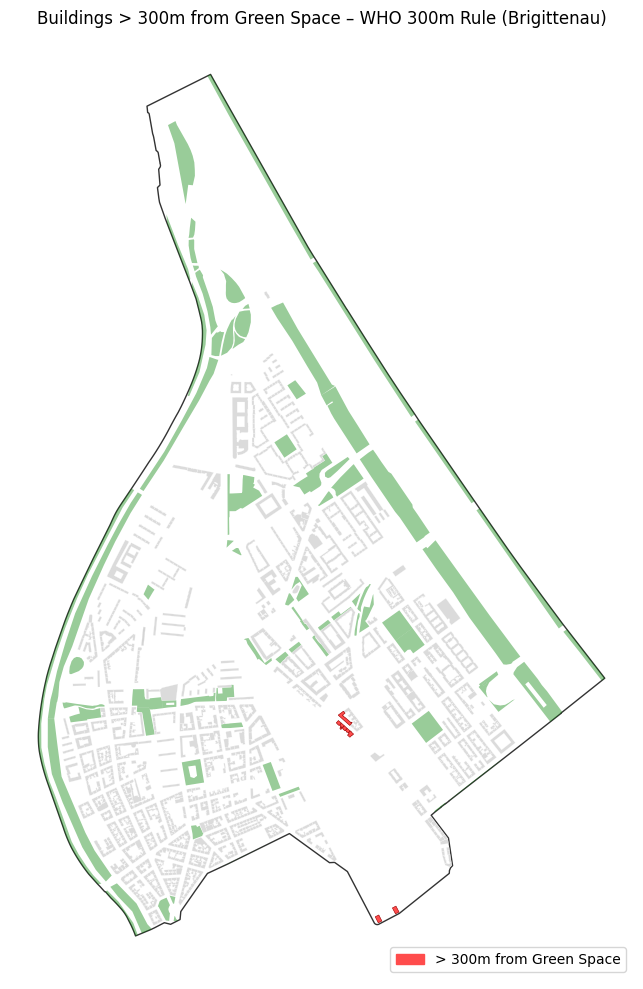


 Processing District: Hernals
Total buildings: 1889
Within 300m: 1749
Compliant: 92.59%


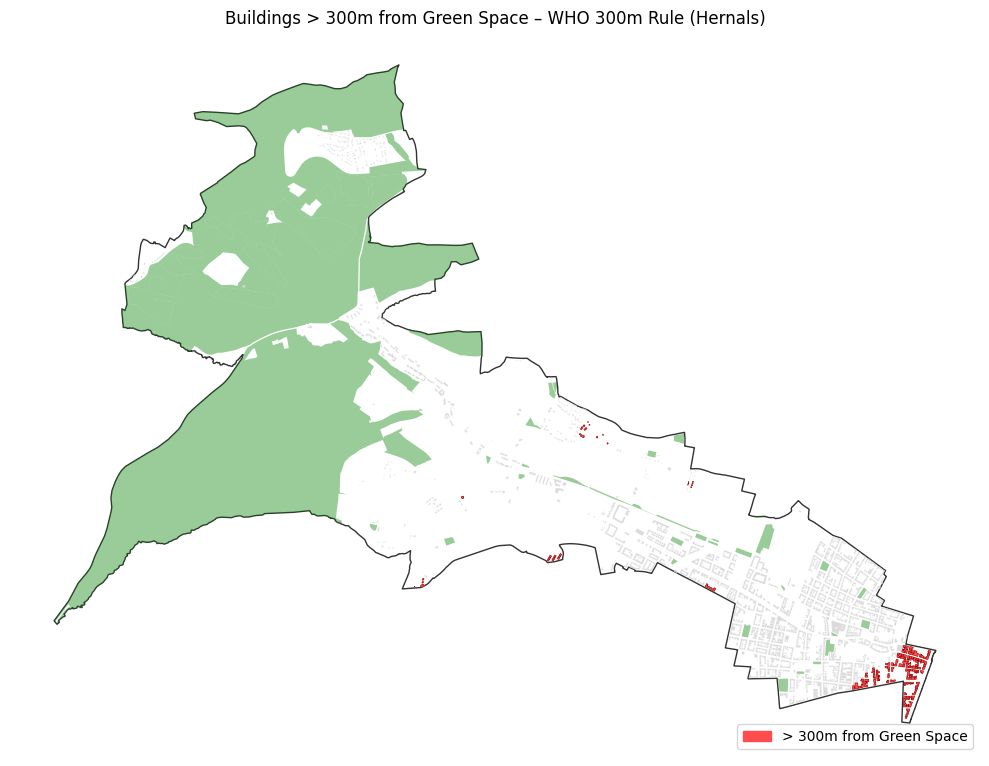


 Processing District: Döbling
Total buildings: 2409
Within 300m: 2347
Compliant: 97.43%


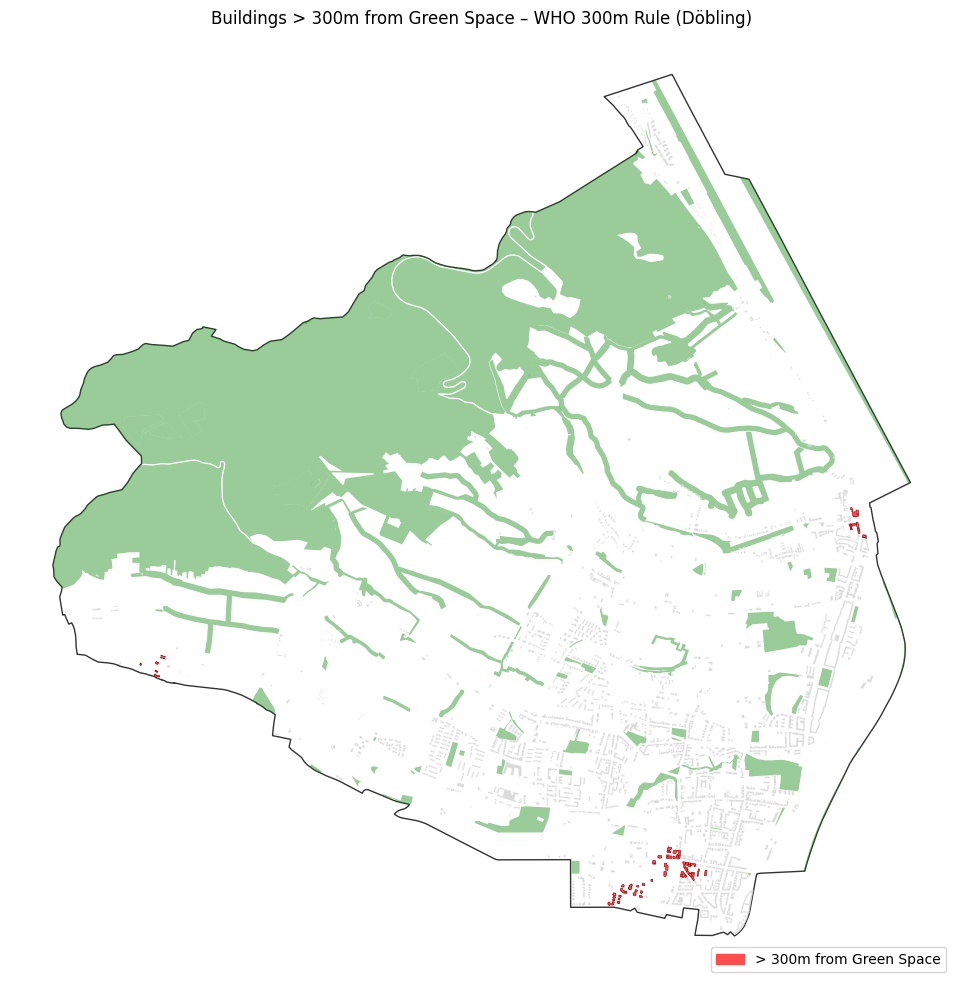


 Processing District: Neubau
Total buildings: 1126
Within 300m: 1109
Compliant: 98.49%


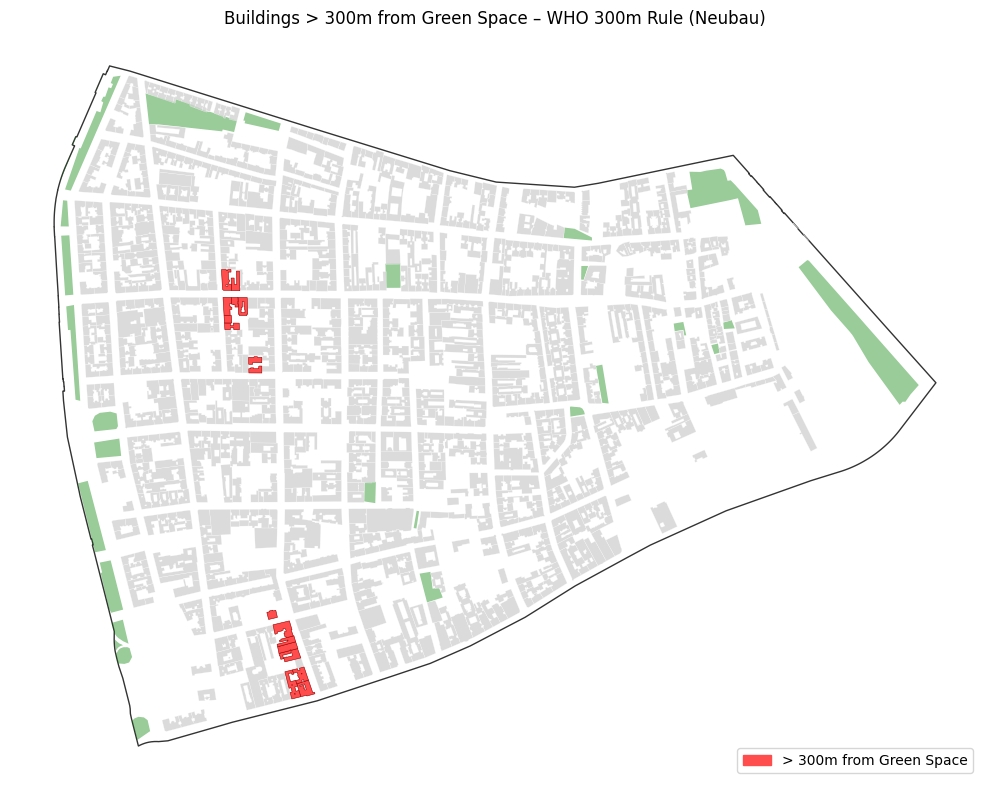


 Processing District: Wieden
Total buildings: 959
Within 300m: 927
Compliant: 96.66%


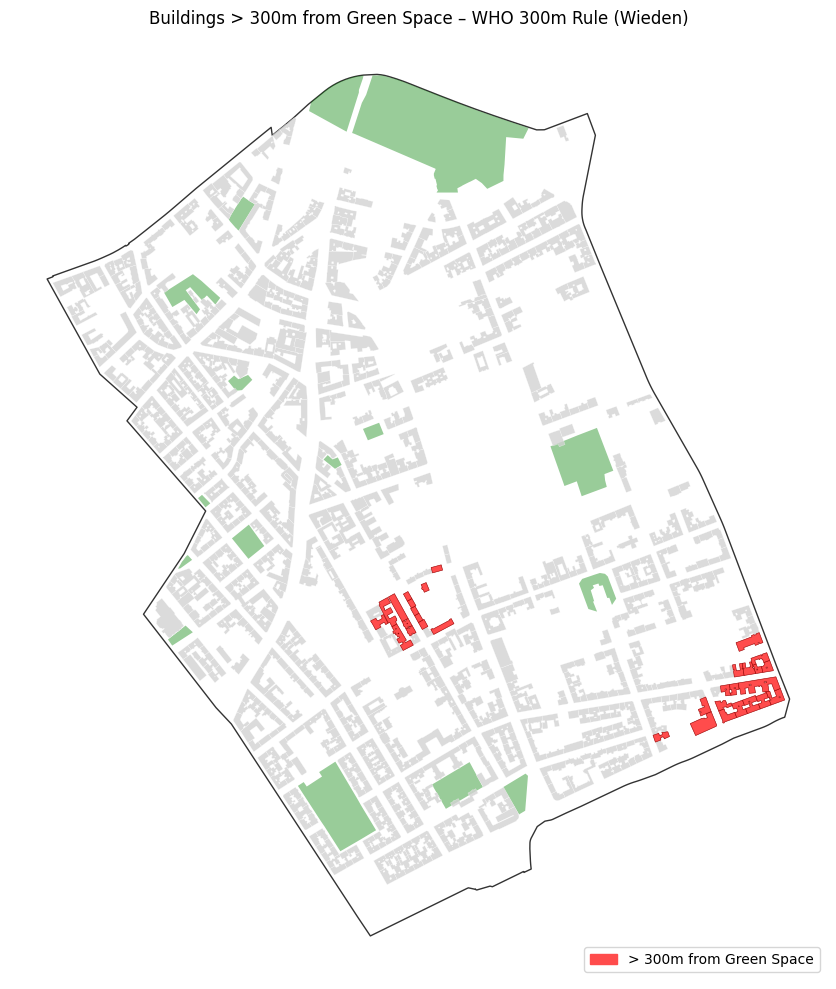


 Processing District: Josefstadt
Total buildings: 691
Within 300m: 616
Compliant: 89.15%


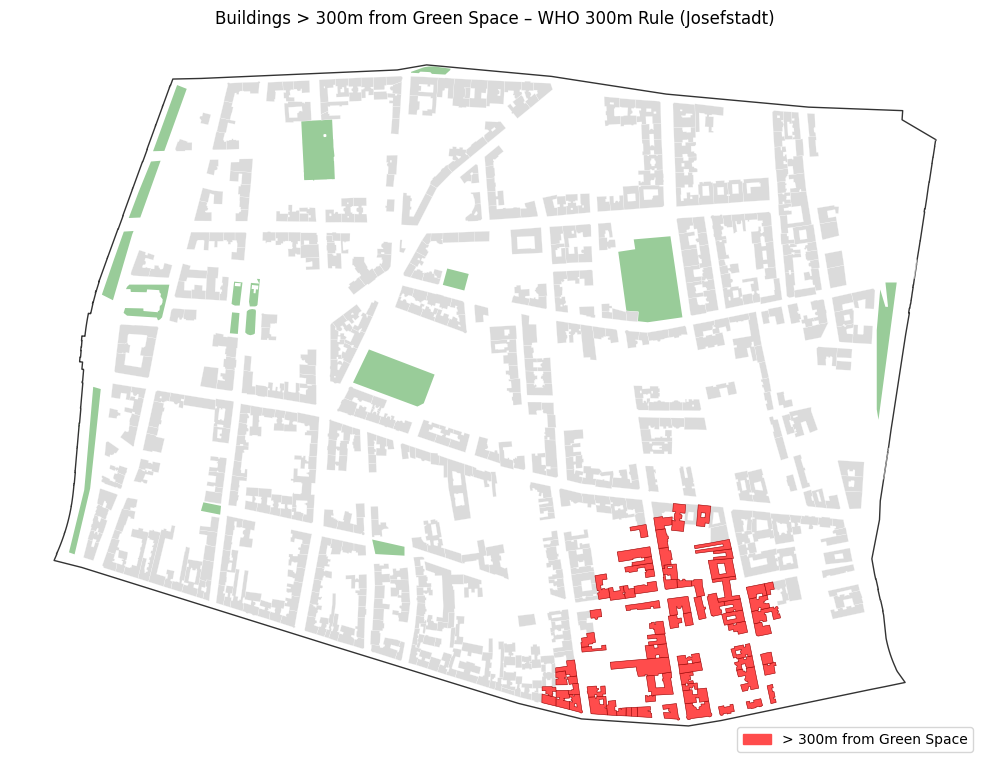


 Processing District: Simmering
Total buildings: 1768
Within 300m: 1723
Compliant: 97.45%


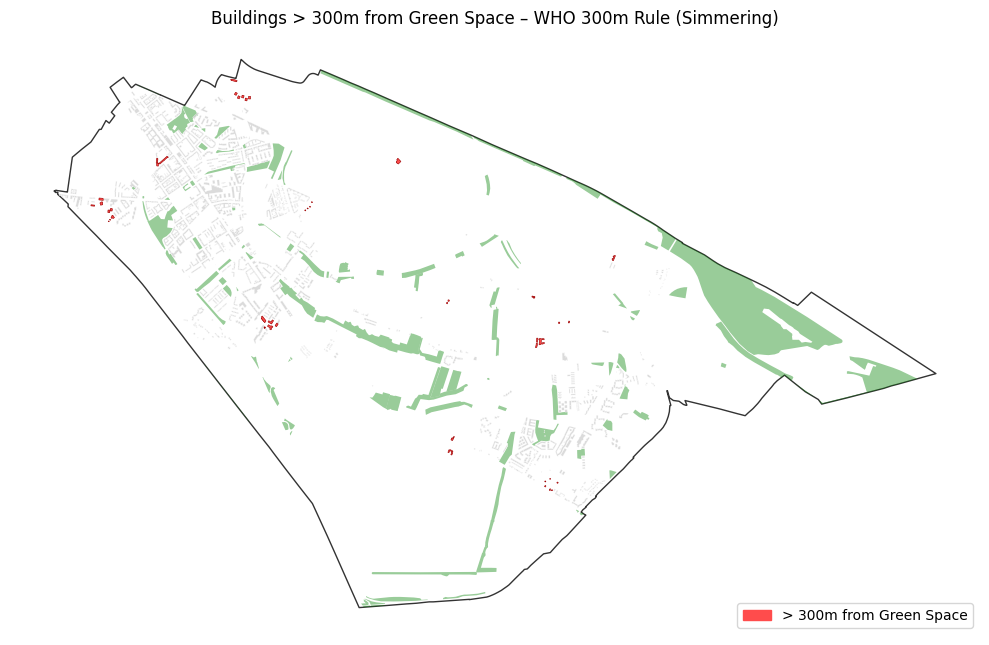


 Processing District: Ottakring
Total buildings: 2703
Within 300m: 2445
Compliant: 90.46%


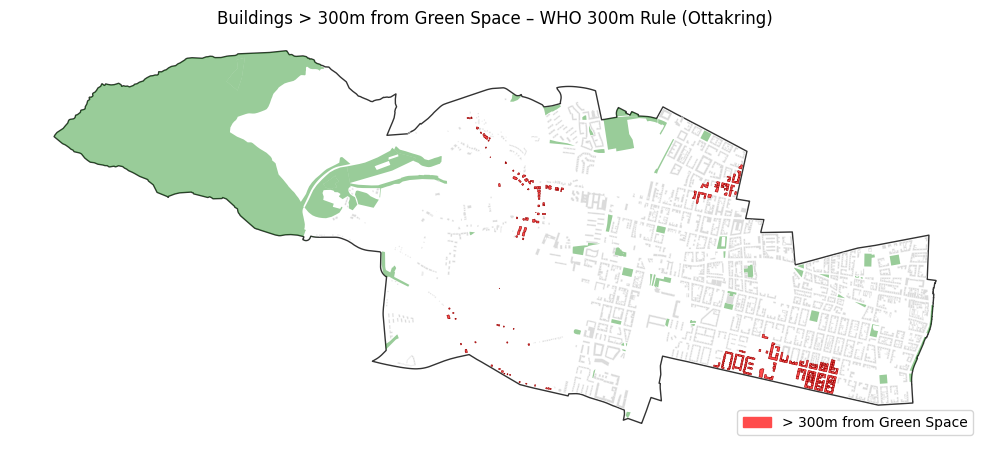


 Processing District: Favoriten
Total buildings: 6051
Within 300m: 5738
Compliant: 94.83%


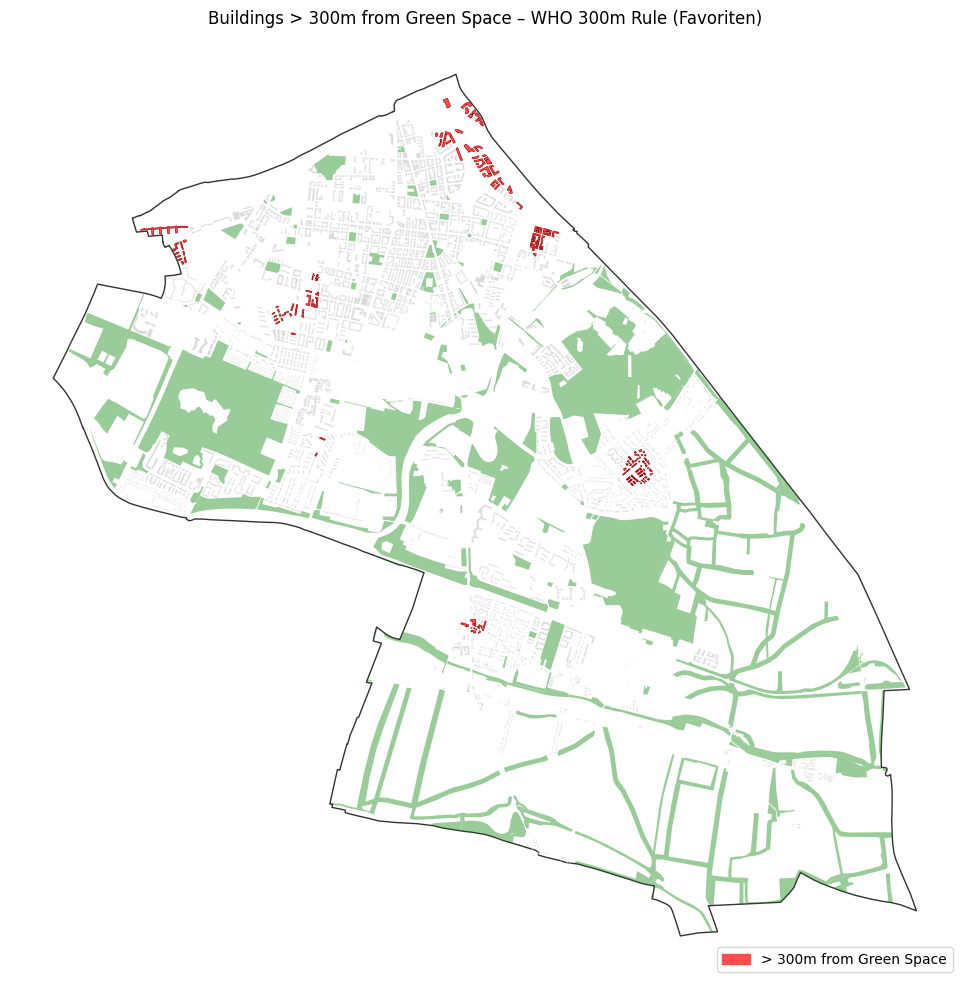


 Processing District: Floridsdorf
Total buildings: 6466
Within 300m: 6036
Compliant: 93.35%


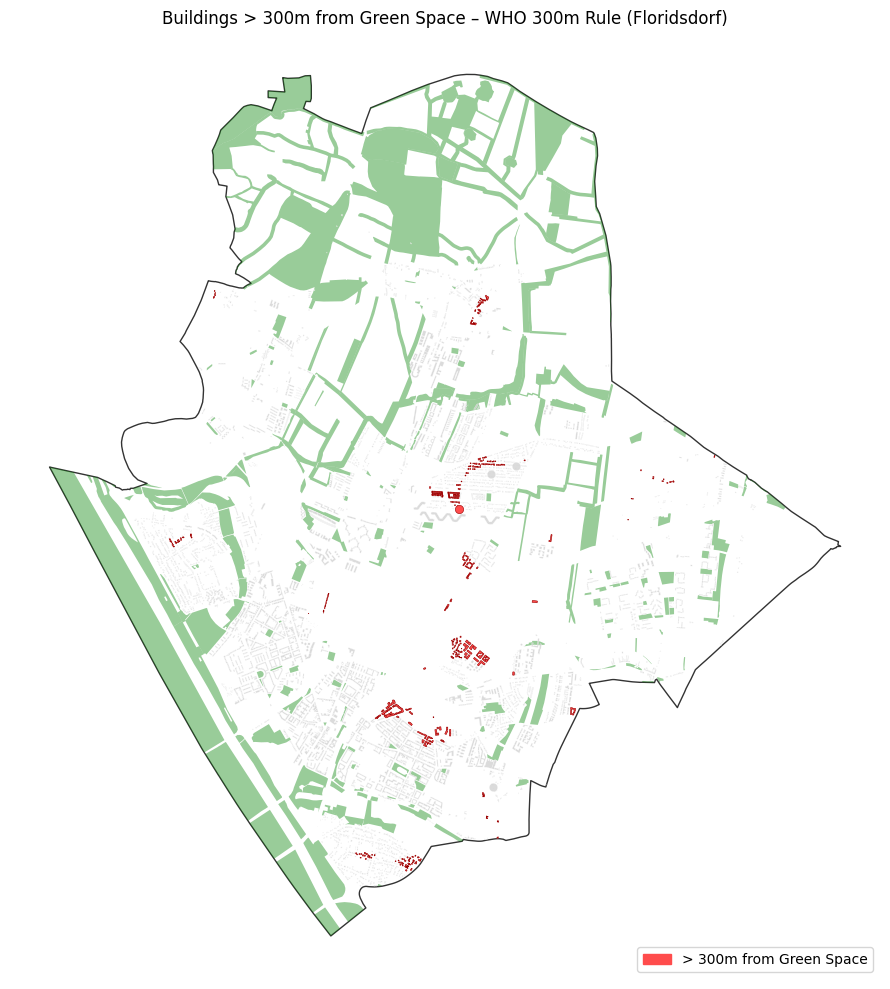


 Processing District: Meidling
Total buildings: 3565
Within 300m: 3198
Compliant: 89.71%


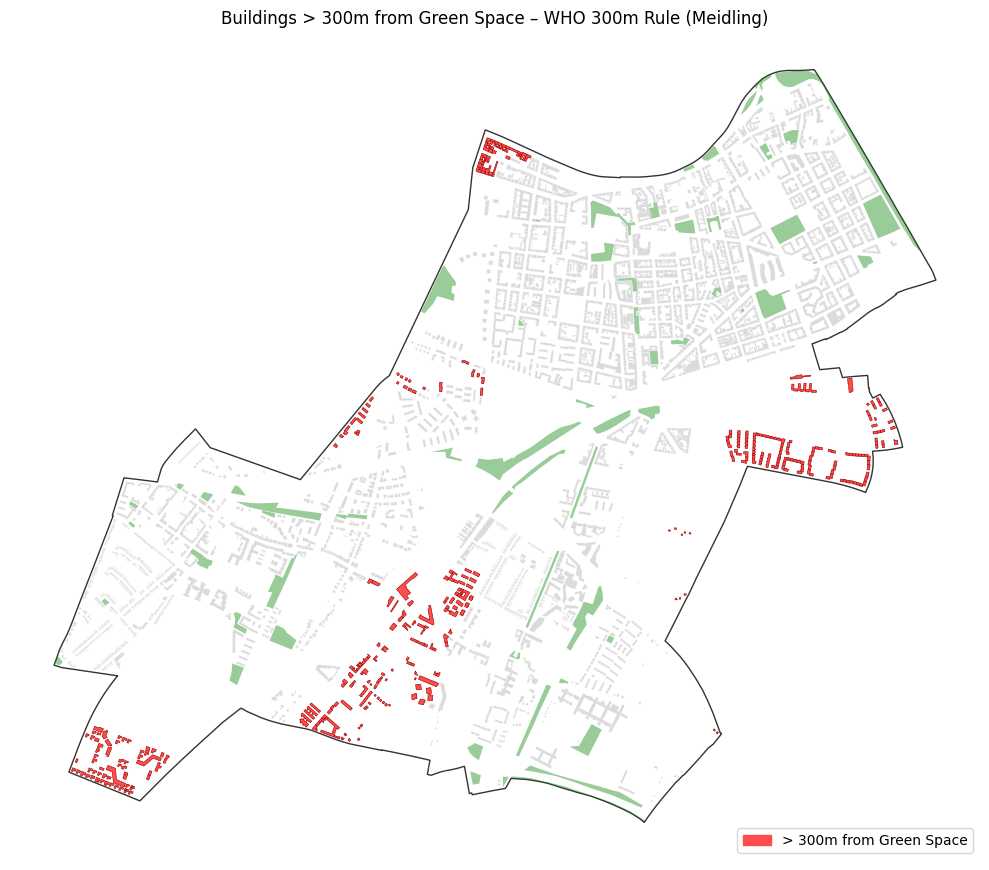


 Processing District: Währing
Total buildings: 1787
Within 300m: 1630
Compliant: 91.21%


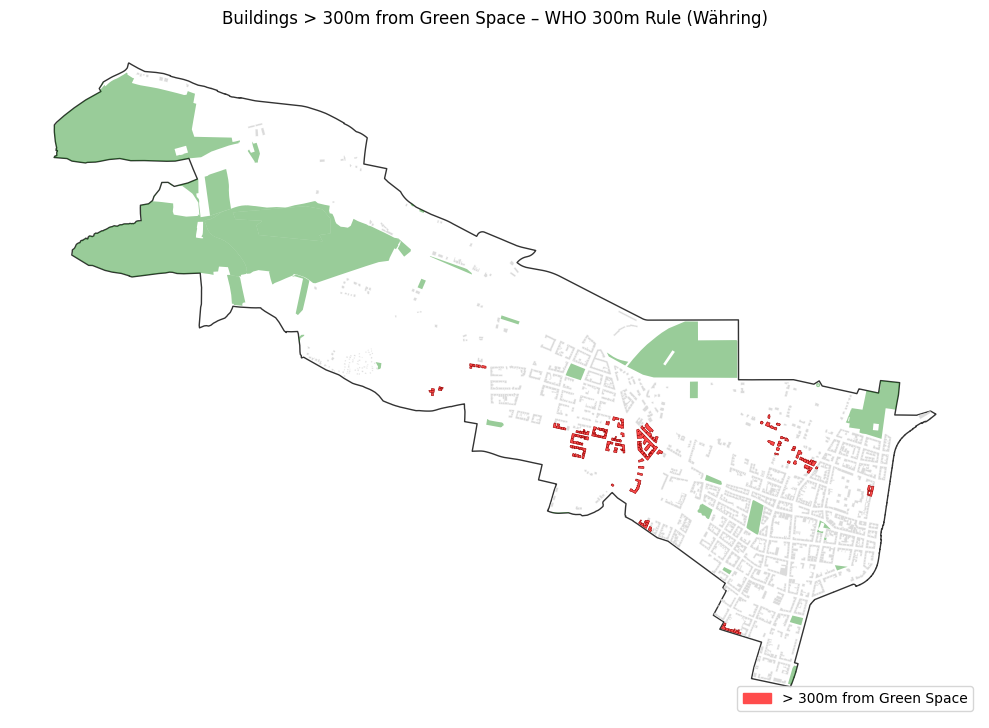


 Processing District: Donaustadt
Total buildings: 11015
Within 300m: 10131
Compliant: 91.97%


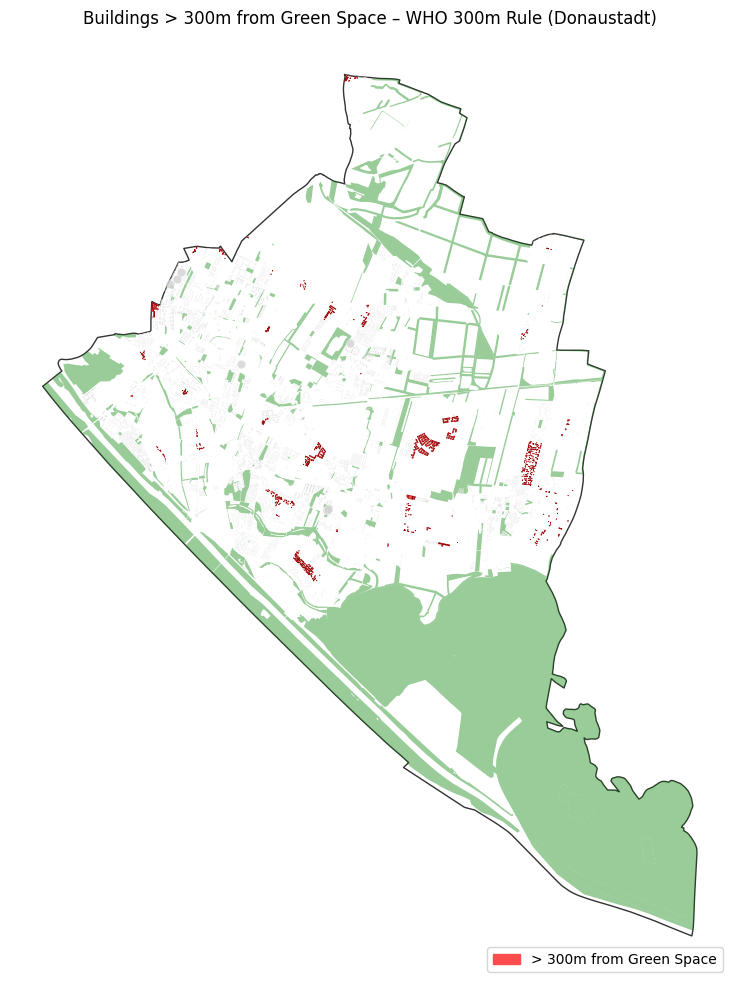


 Processing District: Hietzing
Total buildings: 3079
Within 300m: 2838
Compliant: 92.17%


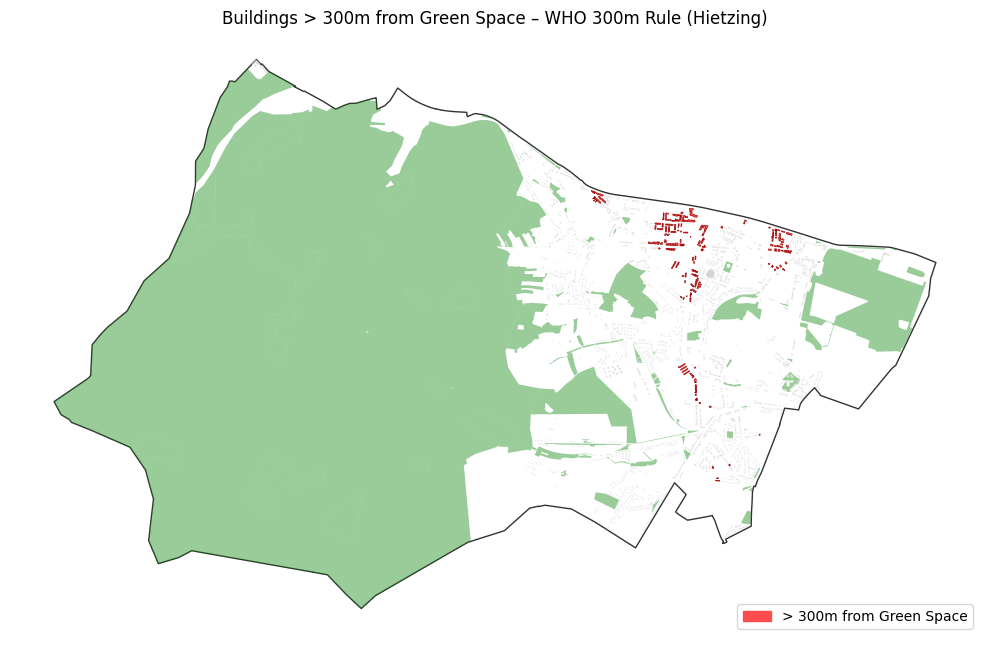


 Processing District: Penzing
Total buildings: 2210
Within 300m: 1997
Compliant: 90.36%


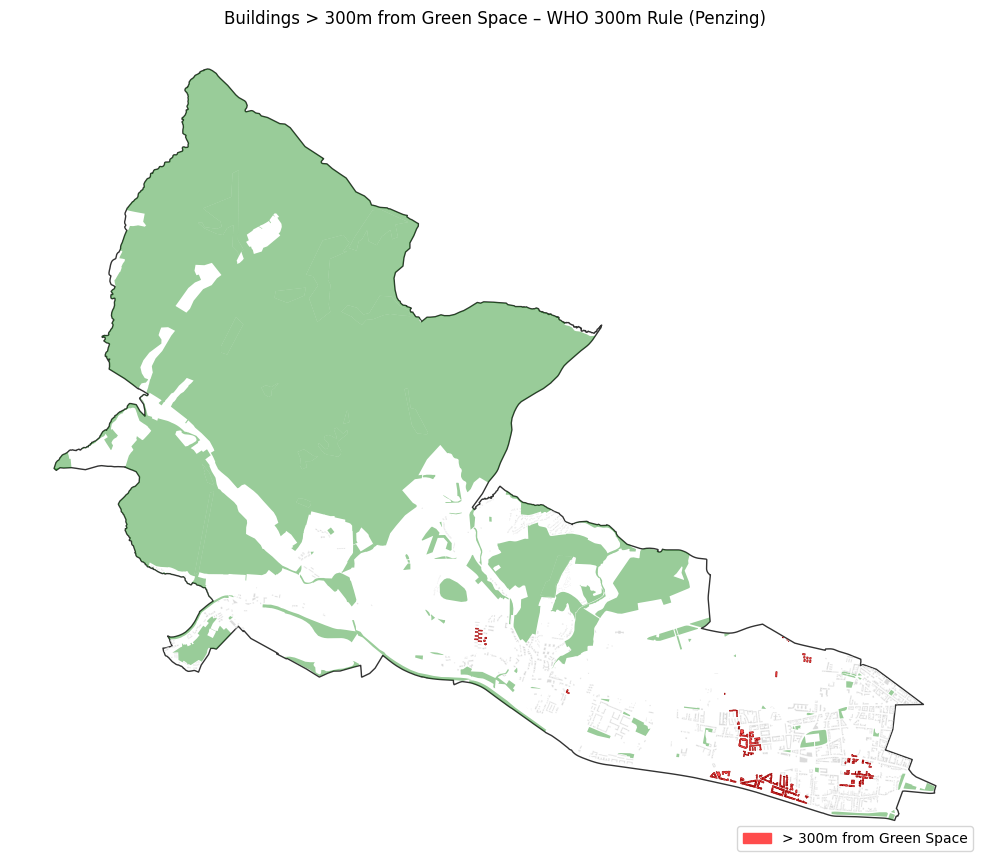


 Processing District: Liesing
Total buildings: 8045
Within 300m: 6714
Compliant: 83.46%


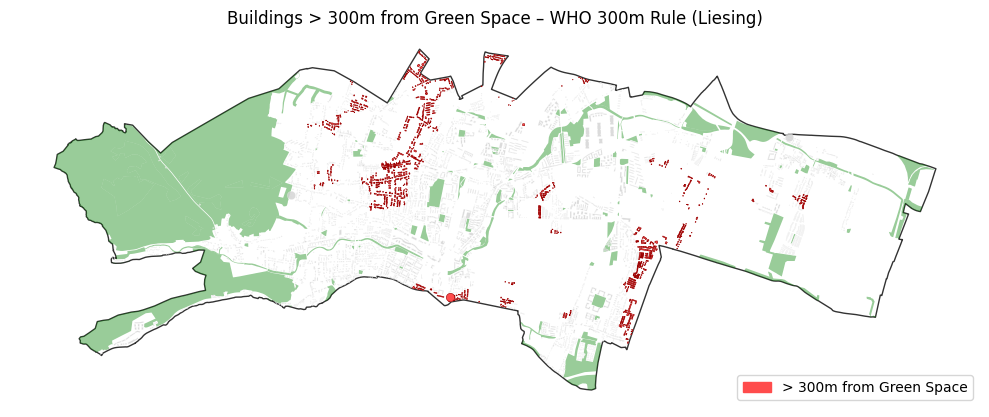


 Processing District: Innere Stadt
Total buildings: 749
Within 300m: 618
Compliant: 82.51%


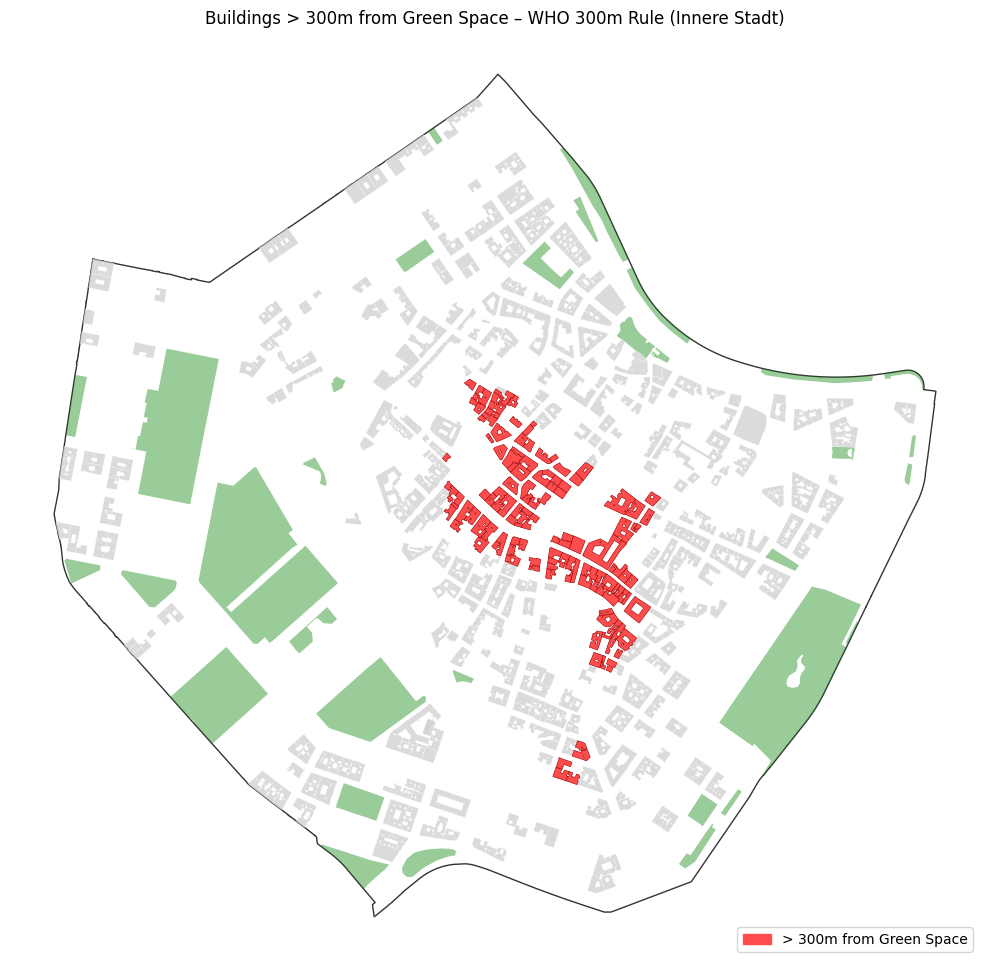

In [ ]:
for num, name in target_districts.items():
    print(f"\n Processing District: {name}")

    # Filter district geometry
    district = districts[districts['NAMEK'] == name]
    if district.empty:
        print(f"District '{name}' not found.")
        continue

    # Align CRS
    residential = residential.to_crs(district.crs)
    green = gdf_green.to_crs(district.crs)

    # Clip buildings and green areas to the district
    residential_clipped = gpd.clip(residential, district)
    green_clipped = gpd.clip(green, district)

    # Reproject everything to EPSG:31256
    crs_proj = 31256
    residential_proj = residential_clipped.to_crs(epsg=crs_proj)
    green_proj = green_clipped.to_crs(epsg=crs_proj)
    district_proj = district.to_crs(epsg=crs_proj)

    # Calculate centroids
    res_centroids = residential_proj.copy()
    res_centroids['geometry'] = res_centroids.centroid

    # Create unified green geometry
    green_union = unary_union(green_proj.geometry)

    # Distance calculation
    res_centroids['distance_to_green'] = res_centroids.geometry.apply(lambda x: x.distance(green_union))
    res_centroids['within_300m'] = res_centroids['distance_to_green'] <= 300

    # Basic stats
    total = len(res_centroids)
    within = res_centroids['within_300m'].sum()
    percent = (within / total) * 100 if total > 0 else 0

    print(f"Total buildings: {total}")
    print(f"Within 300m: {within}")
    print(f"Compliant: {percent:.2f}%")

    # Identify non-compliant buildings
    non_compliant_buildings = residential_proj[~res_centroids['within_300m'].values]

    # Plot and Save
    fig, ax = plt.subplots(figsize=(10, 10))
    district_proj.plot(ax=ax, color='none', edgecolor='#333333')  # Outline
    green_proj.plot(ax=ax, color='green', alpha=0.4)  # Green spaces
    residential_proj.plot(ax=ax, color='#D3D3D3', alpha=0.8, edgecolor='white', linewidth=0.2)  # All buildings
    non_compliant_buildings.plot(ax=ax, color='#FF4C4C', edgecolor='#990000', linewidth=0.4)  # Non-compliant

    # Custom legend fix
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='#FF4C4C', label='> 300m from Green Space')
    plt.legend(handles=[red_patch], loc='lower right')

    # Final touches
    plt.title(f"Buildings > 300m from Green Space – WHO 300m Rule ({name})", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    filename = f"output/who_noncompliant_{name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

